### What is Qformer?



- referenced by : https://github.com/AILab-CVC/SEED

BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models , (Junnan Li et al., PMLR, (2023.01))
- paper : https://arxiv.org/abs/2301.12597
- git-hub : https://github.com/salesforce/LAVIS/tree/main/projects/blip2

<p align="center">
  <img src="./BLIP2.png" alt="nn" width="600"/>
</p>


- BLIP2 저자들은, Image Encoder와 LLM의 end to end 학습의 높은 계산 비용에 대해 고려하며, 
- 그 두 간격을 이을 수 있는 Q-Former 모듈을 통해 Img Encoder 와 LLM을 Freeze하고 서도 VLP(vision-language-pretraining)를 조금 더 효율적으로 성능을 낼 수 있는 방법을 제안합니다.

1. Representation Learning

<p align="center">
  <img src="./qformer_archi.png" alt="nn" width="1500"/>
</p>


2. Generative Learning

<p align="center">
  <img src="./2stage.png" alt="nn" width="1000"/>
</p>


### Q-FORMER

- Learnable Param : 188M
- Q-Former는 두 개의 트랜스포머 서브 모듈로 구성되며, 같은 Self Attention 레이어(주황색)를 공유
- Image Transformer(왼쪽 모듈), Text Transformer(오른쪽 모듈)로 구성됩니다.
- Self Attention 레이어와 Feed Forward는 BERT base의 사전학습 가중치를 사용하고, Cross Attetnion 레이어의 가중치는 랜덤으로 초기화합니다.


### Learnable Queries
- 768차원의 크기를 가진 벡터이며, 총 쿼리의 개수는 32입니다(32 * 768).
출력된 쿼리는 Z 로 나타내며, 크기는 똑같이 (32 * 768)입니다.
- 이는 Frozen image feature(257 * 1024)와 비교했을 때 훨씬 작은 크기인데, 이는 병목 구조로 텍스트와 가장 관련성이 높은 정보를 추출하도록 강제한다고 설명합니다.
- 자세한 설명은 아래 코드와 함께 설명 드리겠습니다.

<p align="center">
  <img src="./BERT.png" alt="nn" width="600"/>
</p>


BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding, (Jacob Devlin, et al. 2019, NAACL) 

### Qformer 생성자

- 본래, Bert에는 cross attention layer가 없었기 때문에  QFormer는 BertLMHeadModel에서 config를 가져와 cross attention layer를 삽입합니다.
- Qformer 가 상속하는 Blip2Base에서는 init_qformer부분에, BertLMHeadModel로 초기화됩니다.
- BertLMHeadModel을 저자들이 수정하여 encoder_hidden_states, encoder_attention_mask, is_decoder 인자를 추가하여 cross attetion을 쓸 수 있는 decoder 모드 Bert로 
확장합니다.

+ 결과적으로 Qformer는 이미지와 텍스트간 modality gap을 줄이기 위해 학습되는 변형된 BERT라고 이해했습니다. (LLM을 위한 번역기)

In [ ]:
import torch.nn  as nn
import torch 

class QFormer(Blip2Base):
    def __init__(
        self, 
        vit_model="clip_B", #본래 eva_clip_g
        img_size = 224,
        drop_path_rate=0,
        use_grad_checkpoint=False,
        vit_precision="fp16",
        freeze_vit = True,
        num_query_token=32,
        cross_attention_freq=2,
        embed_dim=256,
        max_txt_len=32,
    ):
        super().__init__()
        
        
        self.tokenizer= self.init_tokenizer() #BertTokenizer [DEC] speciatl 토큰 추가
        
        self.matching = False 
        self.caption = False 
        
        self.visual_encoder, self.ln_vision = self.init_vision_encoder(
            vit_model, img_size, drop_path_rate, use_grad_checkpoint,  vit_precision
        )
        
        
        if freeze_vit:
            for name, param in self.visual_encoder.named_parameters():
                param.requires_grad= False
                
            self.visual_encoder =self.visual_encoder.eval()
            self.visual_encoder.train = disabled_train 
            
            

        self.Qformer, self.query_tokens = self.init_Qformer(
            num_query_token, self.visual_encoder.config.hidden_size, cross_attention_freq
        ) #Qformer는 BertLMHeadModel, query token(1, 32, hidden_size)
        
        self.Qformer.resize_token_embeddings(len(self.tokenizer)) #bert tokenizer special token추가하고 임베딩 리사이즈
        
        state_dict = self.Qformer.state_dict()
        
        
        for name, param in self.Qformer.named_parameters():
            if "_query" in name:
                key_orig = name.replace("_query", "")
                param.data.copy_(state_dict(key_orig))
                

        # CLS 토큰은 MLM용 Head이기 때문에 학습에서 제외시키고 Freeze
        if not self.caption:
            for name, param in self.Qformer.named_parameters():
                if 'cls.predictions' in name:
                    param.requires_grad =False 
                    
        
                    
        self.vision_proj = nn.Linear(self.Qformer.config.hidden_size, embed_dim)
        self.text_proj = nn.Linear(self.Qformer.config.hidden_size, embed_dim)
        
        if self.matching:
            self.itm_head = nn.Linear(self.Qformer.config.hidden_size, 2)
        
        self.temp = nn.Parameter(0.07 * torch.ones([]))
        self.max_txt_len = max_txt_len
        
        



### Qformer forward 
### 학습 LOSS 

+ ITC + ITM + ITG


### ITC LOSS

- 이미지는 32개의 Query token으로 표현됩니다.

- Image Transformer로부터 출력된 쿼리 Z와 TEXT Transformer로부터 출력된 text representation t끼리 contrastive learning

- Z는 32개의 임베딩 (32 , 768) 로 되어있기 때문에 32개 중 t(1, 768)와 가장 높은 유사도 값을 내적을 통해 구합니다.

- 결과적으로 32, 768 @ 768, 1 -> (32, 1) 중 가장 sim이 높은 값을 선택
- 양방향으로 contrastive learning을 진행하기에 sim_i2t , sim_t2i 의 cross_entropy loss를 구해서 평균낸것을 contrastive loss로 사용합니다.

### ITC_MASK
- 쿼리와 텍스트 사이 정보 누출이 없도록 Uni-modal Self-Attention Mask를 사용
- 이미지와 텍스트를 대조하는 학습이기 때문에, 이미지를 담당하는 쿼리와 텍스트 사이 정보 공유를 방지.

<p align="center">
  <img src="./ITC_mask.png" alt="nn" width="200"/>
</p>


In [ ]:
import torch 

def concat_all_gather():
    """ temp """
    return 0 


image_feats = torch.randn((224,224,3))
text_feat = "" 
###============== Image-text Contrastive ===================###
import torch.nn.functional as F 

class Qformer():
    def __init__(self, 
        vit_model="clip_B", #본래 eva_clip_g
        img_size = 224,
        drop_path_rate=0,
        use_grad_checkpoint=False,
        vit_precision="fp16",
        freeze_vit = True,
        num_query_token=32,
        cross_attention_freq=2,
        embed_dim=256,
        max_txt_len=32,):

        pass 
    
    def forward(self, sample):
        image = sample['image']
        text = sample['caption']


        """"GPU 개수 만큼 batch_size에 곱한 것과 embed dim으로 concat해줍니다. DDP 과정 """
        image_feats_all = concat_all_gather(
            image_feats
        )  # [batch_size*num_gpu, num_query_tokens, embed_dim]
        text_feat_all = concat_all_gather(text_feat)  # [batch_size*num_gpu, embed_dim]



        """"image qeuery하나와 text 전부의 similarity 계산"""
        sim_q2t = torch.matmul(
            image_feats.unsqueeze(1), text_feat_all.unsqueeze(-1)
        ).squeeze()
        # [batch_size, batch_size*num_gpu, num_query_tokens]

        # image-text similarity: aggregate across all query tokens
        sim_i2t, _ = sim_q2t.max(-1)
        #sim_i2t = sim_q2t.mean(-1)
        sim_i2t = sim_i2t / self.temp



        """"text 하나와 image 전부의 similarity 계산"""
        # text-query similarity: [batch_size, batch_size*num_gpu, num_query_tokens]
        sim_t2q = torch.matmul(
            text_feat.unsqueeze(1).unsqueeze(1), image_feats_all.permute(0, 2, 1)
        ).squeeze()

        # text-image similarity: aggregate across all query tokens
        sim_t2i, _ = sim_t2q.max(-1)
        #sim_t2i = sim_t2q.mean(-1)
        sim_t2i = sim_t2i / self.temp  # [batch_size, batch_size*num_gpu]
        rank = 0
        bs = image.size(0)
        targets = torch.linspace(rank * bs, rank * bs + bs - 1, bs, dtype=int).to(
            image.device
        )

        loss_itc = (
            F.cross_entropy(sim_i2t, targets, label_smoothing=0.1)
            + F.cross_entropy(sim_t2i, targets, label_smoothing=0.1)
        ) / 2


### ITM LOSS 

- 주어지는 IMG와 TEXT가 match 하는지 학습하는 단계입니다. 
- 이 단계에서는 Binary (0,1) 로 IMG와 TEXT 매치되게 예측하는지 학습합니다.


### ITM_MASK
- Bi-directional Self-Attention Mask를 적용하여 Query와 Text가 서로 참조할 수 있도록 합니다.
- 모든 Query의 logit의 mean을 match score로 사용합니다.

- 이때, ITC Loss를 구하기 위해 구했던 sim_i2t, sim_t2i를 통해 가장 헷갈려하는 negative sample을 정답쌍과 함께 포함하여

- (IMG,TEXT) = ( Pos, Pos ) ( Neg, Pos ) ( Pos, Neg ) 쌍과 함께 Label (1, 0, 0) 의 형태로 만들어 Binary Match를 학습시킵니다.

<p align="center">
  <img src="./ITM_mask.png" alt="nn" width="200"/>
</p>


In [ ]:
import torch 

def concat_all_gather():
    """ temp """
    return 0 

def all_gather_with_grad():
    """ temp """
    return 0 

sim_i2t = 0  #temp 
sim_t2i = 0  #temp

image_feats = torch.randn((224,224,3))
text_feat = "" 

###============== Image-text Matching ===================###


import torch.nn.functional as F 


class Qformer():
    def __init__(self, 
        vit_model="clip_B", #본래 eva_clip_g
        img_size = 224,
        drop_path_rate=0,
        use_grad_checkpoint=False,
        vit_precision="fp16",
        freeze_vit = True,
        num_query_token=32,
        cross_attention_freq=2,
        embed_dim=256,
        max_txt_len=32,):

        pass 
    
    def forward(self, sample):
        image = sample['image']
        text = sample['caption']
        
        """ VIT를 통과한 후 vision feature를 추출"""
        vit_out = self.visual_encoder(image)
        image_embeds = self.ln_vision(vit_out.last_hidden_state) 
        

        """이미지 attention 마스크 설정 (전부 볼 수 있게 ITM에서는 )"""
        image_atts =  torch.ones(image_embeds.size()[:-1], dtype =torch.long).to(image.device)
        
        
        """ Batch Size에 맞게끔 복제해서 expand query_tokens(1, num_query, hidden_dim) -> (B, num_query, hidden_dim)"""
        query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)
        



        """보통 BERT는 token_ids를 받지만, 학습가능한 Query token( 임베딩 벡터) 를 직접 주입
         
        encoder_hidden_states = image_embeds : ViT가 뽑은 Feature map이 들어감.
        encoder_attention_mask : 어떤 이미지가 실제 유효한지 알려주는 마스크.  모든 이미지를 다 쓰려면 1로, 패딩된 부분은 0으로 설정합니다. Cross-attention 시 불필요한 패딩을 무시하기 위한 장치.

        """
        query_output = self.Qformer.bert(
            inputs_embeds = query_tokens,   # 학습 가능한 쿼리 토큰 (텍스트 토큰 대신 직접 임베딩을 입력)
            encoder_hidden_states = image_embeds,  # ViT 등에서 추출된 이미지 임베딩 → Cross-Attention에서 참고 (기존 버트와 달라진 점)
            encoder_attention_mask = image_atts, # 이미지 토큰 중 어떤 걸 볼 수 있는지 표시 (여기선 전부 1 → 전부 참조 가능)
            use_cache=True,   # Transformer 캐시 사용 (추론/생성 속도 최적화)
            return_dict =True, # 출력 형태를 dict로 (last_hidden_state, hidden_states, attentions 등 접근 가능)
            output_attentions=True, #직접 넣은 것 (attention map 시각화를 위해)
        )
        
        """bert tokenizing 과정"""
        text_tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation= True,
            max_length=self.max_txt_len,
            return_tensors="pt",
        ).to(image.device)
        
        
        """ BERT 에 
            text_toekn.input_ids 주입
            text_attention_mask : 어떤 이미지가 실제 유효한지 알려주는 마스크.  모든 이미지를 다 쓰려면 1로, 패딩된 부분은 0으로 설정합니다. Cross-attention 시 불필요한 패딩을 무시하기 위한 장치.
        """
        text_output= self.Qformer.bert(
            text_tokens.input_ids,
            attention_mask=text_tokens.attention_mask,
            return_dict=True, 
        )
        
        rank = 0 # dist.get_rank() # DDP get_rank
        bs = image.size(0) #batch size
        
        

        loss_itm = 0.0
        if self.matching:
            text_input_ids_world = concat_all_gather(text_tokens.input_ids)
            text_attention_mask_world = concat_all_gather(text_tokens.attention_mask)
            image_embeds_world = all_gather_with_grad(image_embeds)


            # Negative Sampling을 위한 작업
            """weights_t2i 각 텍스트에 대한 모든 이미지 확률 분포로 softmax  
               weights_i2t 각 이미지에 대한 모든 텍스트 확률 분포로 softmax
               weigts.fill_diagonal_(0) → 자기 자신(text와 매칭되는 정답 image)은 0으로 강제로 막음.

               contrastive loss 계산할 때 정답 쌍은 제외하고, 나머지를 negative sample로 쓰기 위함.
            """
            with torch.no_grad():
                weights_t2i = F.softmax(sim_t2i, dim=1) + 1e-4
                weights_t2i[:, rank * bs : rank * bs + bs].fill_diagonal_(0)
                weights_i2t = F.softmax(sim_i2t, dim=1) + 1e-4
                weights_i2t[:, rank * bs : rank * bs + bs].fill_diagonal_(0)


            """Image Negative 쌍 선택
               B번째 배치(t2i이면) text 쿼리에 대해 대응하는 negative image 하나 뽑아서 neg list에 추가

               i2t이면 image 쿼리에 대응하는 negative text  하나 뽑아서 추가.

               이때, torch.multinomial 을 쓰는 이유는. 유사도가 높은 이미지,텍스트 일수록 더 잘뽑히게. (헷갈리는 어려운 샘플을) neg에 추가.
            """
            # select a negative image for each text
            image_embeds_neg = []
            for b in range(bs):
                neg_idx = torch.multinomial(weights_t2i[b], 1).item()
                image_embeds_neg.append(image_embeds_world[neg_idx])
            image_embeds_neg = torch.stack(image_embeds_neg, dim=0)

            """Text Negative 쌍 선택"""
            # select a negative text for each image
            text_ids_neg = []
            text_atts_neg = []
            for b in range(bs):
                neg_idx = torch.multinomial(weights_i2t[b], 1).item()
                text_ids_neg.append(text_input_ids_world[neg_idx])
                text_atts_neg.append(text_attention_mask_world[neg_idx])

            text_ids_neg = torch.stack(text_ids_neg, dim=0)
            text_atts_neg = torch.stack(text_atts_neg, dim=0)

            """text : POS POS NEG """
            text_ids_all = torch.cat(  
                [text_tokens.input_ids, text_tokens.input_ids, text_ids_neg], dim=0
            )  # pos, pos, neg
            text_atts_all = torch.cat(
                [text_tokens.attention_mask, text_tokens.attention_mask, text_atts_neg],
                dim=0,                  
            )  # (B+B, N)
            


            """Query 토큰에 Text_ids_all 담음 for ITM"""
            query_tokens_itm = self.query_tokens.expand(text_ids_all.shape[0], -1, -1) #B NQ H 
            query_atts_itm = torch.ones(query_tokens_itm.size()[:-1], dtype=torch.long).to(  # B NQ에 1로 채워서 모두 볼수 있게
                image.device
            )
            
            """Attention? maks"""
            attention_mask_all = torch.cat([query_atts_itm, text_atts_all], dim=1) #(B, NQ + NT)

            """image : POS NEG POS """
            image_embeds_all = torch.cat(
                [image_embeds, image_embeds_neg, image_embeds], dim=0  #( B+B+B, NQ) 
            )  # pos, neg, pos


            # (B*3, num_patches) 크기의 마스크, 모든 이미지 패치를 볼 수 있도록 1로 채움
            image_atts_all = torch.ones(image_embeds_all.size()[:-1], dtype=torch.long).to(
                image.device
            )


            """output_itm bert"""
            output_itm = self.Qformer.bert(
                text_ids_all,
                inputs_embeds=query_tokens_itm,
                attention_mask=attention_mask_all, #decoder/query 부분 마스크 self-attention할때 무시할 토큰
                encoder_hidden_states=image_embeds_all,
                encoder_attention_mask=image_atts_all, #encoder/iamge 부분 마스크 cross-attention할때 유효한 부분 알려줌
                return_dict=True,
            )


            """마지막 hidden state의 정보 뽑음."""
            vl_embeddings = output_itm.last_hidden_state[:, : query_tokens_itm.size(1), :] 
            vl_output = self.itm_head(vl_embeddings) # (Qformer. hidden , 2) 0,1 차원
            logits = vl_output.mean(dim=1)


            """(Pos,Pos) (Pos,Neg), (Neg, Pos) 쌍이기 때문에, 답을 이렇게 bs 3개를 1:2로쪼개 label을 생성"""
            itm_labels = torch.cat(
                [torch.ones(bs, dtype=torch.long), torch.zeros(2 * bs, dtype=torch.long)],
                dim=0,
            ).to(image.device)


            
            """ logits 와 itm label cross entropy loss 구하기 """
            loss_itm = F.cross_entropy(logits, itm_labels) # 분류 로스


### ITG LOSS 

- Q-Former가 입력 이미지로부터 텍스트를 생성하도록 학습
- 구조상 텍스트 트랜스포머가 이미지의 정보를 직접적으로 활용할 수 없기때문에 Self-Attention 레이어에서 Query의 정보를 강제적으로 사용하게 됩니다.
- 기존 BERT는 CLS 토큰을 활용하여 Classification 위해 [CLS] 토큰을 넣고, 마지막 hidden state를 활용하였으나, 
- Qformer에서는 DEC토큰으로 교체하여 텍스트를 생성할 수 있게 합니다.

### ITG_mask
- Multimodal Causal Self-Attention Mask를 적용하여 쿼리는 텍스트 토큰을 참조하지 못하도록, 텍스트 토큰은 쿼리의 정보와 이전 텍스트 토큰만을 참조할 수 있도록 마스크를 통해 학습시킵니다.

<p align="center">
  <img src="./ITG_mask.png" alt="nn" width="200"/>
</p>


In [ ]:

            

class Qformer():
    def __init__(self, 
        vit_model="clip_B", #본래 eva_clip_g
        img_size = 224,
        drop_path_rate=0,
        use_grad_checkpoint=False,
        vit_precision="fp16",
        freeze_vit = True,
        num_query_token=32,
        cross_attention_freq=2,
        embed_dim=256,
        max_txt_len=32,):

        pass 
    
    def forward(self, sample):
            
            """temp"""
            
            
            ##================= Image Captioning ========================##
            loss_lm = 0.0
            if self.caption:
                decoder_input_ids = text_tokens.input_ids.clone()
                """BOS 토큰을 CLS 가 아니라 DEC 추가해서"""
                decoder_input_ids[:, 0] = self.tokenizer.bos_token_id




                
                """[PAD] 토큰을 찾아서 전부 -100으로 바꾸고 나머지 토큰은 그대로 둠, ITC, ITM과 달리 text 토큰을
                생성하는 단계이기 때문에, [PAD] 토큰이 발생했을 때, 이를 Loss에 포함시키지 않고자 -100으로 바꿈"""
                labels = decoder_input_ids.masked_fill(
                    decoder_input_ids == self.tokenizer.pad_token_id, -100
                )

                query_atts = torch.ones(query_tokens.size()[:-1], dtype=torch.long).to(
                    image.device
                )

                """decoder용 마스크 생성"""
                attention_mask = torch.cat([query_atts, text_tokens.attention_mask], dim=1)
                
                
                """decoder용 마스크 생성

                past_key_values 의미 : 
                Q-Former가 앞에서 query 토큰과 cross-attention 계산할 때 만든 K/V 캐시.
                이걸 LM 디코더에 넘겨서 query와 이미지 임베딩을 다시 안 계산하고 바로 재사용.
                
                """
                lm_output = self.Qformer(
                    decoder_input_ids,
                    attention_mask=attention_mask,
                    past_key_values=query_output.past_key_values,
                    return_dict=True,
                    labels=labels,
                )

                loss_lm = lm_output.loss

            return BlipOutput(
                loss=loss_itc + loss_itm + loss_lm,
                loss_itc=loss_itc,
                loss_itm=loss_itm,
                loss_lm=loss_lm,
            )

            

### Inference 전용 함수

In [ ]:
class Qformer():
    """Temp"""
    @torch.no_grad()
    def generate(
        self,
        samples,
        use_nucleus_sampling=False,
        num_beams=3,
        max_length=30,
        min_length=10,
        top_p=0.9,
        repetition_penalty=1.0,
    ):
        """
        Args:
            samples (dict): A dictionary containing the following keys:
                - image (torch.Tensor): A tensor of shape (batch_size, 3, H, W)
            use_nucleus_sampling (bool): Whether to use nucleus sampling. If False, use top-k sampling.
            num_beams (int): Number of beams for beam search. 1 means no beam search.
            max_length (int): The maximum length of the sequence to be generated.
            min_length (int): The minimum length of the sequence to be generated.
            top_p (float): The cumulative probability for nucleus sampling.
            repetition_penalty (float): The parameter for repetition penalty. 1.0 means no penalty.
            num_captions (int): Number of captions to be generated for each image.
        Returns:
            captions (list): A list of strings of length batch_size * num_captions.
        """
        image = samples["image"]
        image_embeds = self.ln_vision(self.visual_encoder(image))

        if not use_nucleus_sampling:
            image_embeds = image_embeds.repeat_interleave(num_beams, dim=0)
        else:
            num_beams = 1
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(
            image.device
        )

        model_kwargs = {
            "encoder_hidden_states": image_embeds,
            "encoder_attention_mask": image_atts,
        }
        
        # [B,1] 크기의 입력 토큰: <bos> (문장 시작 토큰)
        input_ids = (
            torch.LongTensor(image.size(0), 1)
            .fill_(self.tokenizer.bos_token_id)
            .to(image.device)
        )
        query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)

        outputs = self.Qformer.generate(
            input_ids=input_ids,
            query_embeds=query_tokens,
            max_length=max_length,
            min_length=min_length,
            num_beams=num_beams,
            do_sample=use_nucleus_sampling,
            top_p=top_p,
            eos_token_id=self.tokenizer.sep_token_id,
            pad_token_id=self.tokenizer.pad_token_id,
            **model_kwargs
        )
        captions = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)
        return captions

### Pre-Training Data


- 사전 학습 데이터의 이미지는 총 129M개
-  COCO, Visual Genome, CC3M, CC12M, SBU, LAION400M 데이터셋으로부터 가져온 115M개가 포함
- 캡션은 BLIP의 CapFilt 방법을 사용하여 선별된 캡션과 원본 캡션 중 랜덤 샘플링하여 사용

### Qformer의 동작확인
- 학습 없는 상태

#### Lavis.base_model

In [1]:
rank, num_tasks = 0, 1

In [ ]:
from collections import OrderedDict
from itertools import repeat
import collections.abc
import math

import torch
import torch.nn.functional as F
from torch import nn

from fairscale.nn.checkpoint.checkpoint_activations import checkpoint_wrapper

# from lavis.models.eva_vit import convert_weights_to_fp16, convert_weights_clip
# from lavis.common.dist_utils import download_cached_file
# from timm.models import create_model
# from lavis.models.blip2_models.beit2 import modeling_vqkd 
# from lavis.models.blip2_models.mage import models_vit_mage
# from lavis.models.blip2_models.mage.util.pos_embed import interpolate_pos_embed_mage

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        return x[0]
    

class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None, use_grad_checkpointing=False):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

        if use_grad_checkpointing:
            self.attn = checkpoint_wrapper(self.attn)
            self.mlp = checkpoint_wrapper(self.mlp)
            
    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None, use_grad_checkpointing=False):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask, use_grad_checkpointing and i>12) for i in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, use_grad_checkpointing: bool):
        super().__init__()
        self.input_resolution = input_resolution
        self.num_features = width
        self.num_heads = heads
        self.num_patches = (input_resolution // patch_size) ** 2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn(self.num_patches + 1, width))
        self.ln_pre = LayerNorm(width)
        
        #self.transformer = Transformer(width, layers-1, heads, use_grad_checkpointing=use_grad_checkpointing)
        self.transformer = Transformer(width, layers, heads, use_grad_checkpointing=use_grad_checkpointing)
           
        #self.ln_final = LayerNorm(width)

    def forward(self, x: torch.Tensor):

        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        
        #x = self.ln_final(x)
        return x
    
    
            
# From PyTorch internals
def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_2tuple = _ntuple(2)        

def interpolate_pos_embed(model, state_dict, interpolation: str = 'bicubic', seq_dim=1):
    # Rescale the grid of position embeddings when loading from state_dict
    old_pos_embed = state_dict.get('positional_embedding', None)
    
    grid_size = round((model.positional_embedding.shape[0] - 1) ** 0.5)
    if old_pos_embed is None:
        return
    grid_size = to_2tuple(grid_size)
    extra_tokens = 1  # FIXME detect different token configs (ie no class token, or more)
    new_seq_len = grid_size[0] * grid_size[1] + extra_tokens
    if new_seq_len == old_pos_embed.shape[0]:
        return

    if extra_tokens:
        pos_emb_tok, pos_emb_img = old_pos_embed[:extra_tokens], old_pos_embed[extra_tokens:]
    else:
        pos_emb_tok, pos_emb_img = None, old_pos_embed
        
    old_grid_size = to_2tuple(int(math.sqrt(len(pos_emb_img))))

    print('Resizing position embedding grid-size from %s to %s', old_grid_size, grid_size)
    pos_emb_img = pos_emb_img.reshape(1, old_grid_size[0], old_grid_size[1], -1).permute(0, 3, 1, 2)
    pos_emb_img = F.interpolate(
        pos_emb_img,
        size=grid_size,
        mode=interpolation,
        align_corners=True,
    )
    pos_emb_img = pos_emb_img.permute(0, 2, 3, 1).reshape(1, grid_size[0] * grid_size[1], -1)[0]
    if pos_emb_tok is not None:
        new_pos_embed = torch.cat([pos_emb_tok, pos_emb_img], dim=0)
    else:
        new_pos_embed = pos_emb_img
    state_dict['positional_embedding'] = new_pos_embed
    
    
def create_clip_vit_L(img_size=224,use_checkpoint=False,precision="fp16"):
    model = VisionTransformer(
            input_resolution=img_size,
            patch_size=14,
            width=1024,
            layers=22,
            heads=16,
            use_grad_checkpointing=use_checkpoint,
        )         
    url = "https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP2/clip_vit_L.pth"
    cached_file = download_cached_file(
        url, check_hash=False, progress=True
    )
    state_dict = torch.load(cached_file, map_location="cpu")    
    interpolate_pos_embed(model,state_dict)
    
    incompatible_keys = model.load_state_dict(state_dict, strict=False)
    # print(incompatible_keys)
    
    if precision == "fp16":
        convert_weights_to_fp16(model)
    return model
from transformers import ViTModel

def create_clip_vit_B(img_size=224, use_checkpoint=False, precision="fp16"):
    # HuggingFace pretrained ViT 불러오기
    model = ViTModel.from_pretrained("google/vit-base-patch16-224")
    return model




c:\Users\user\anaconda3\envs\ocr_last\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\anaconda3\envs\ocr_last\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\user\anaconda3\envs\ocr_last\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\user\anaconda3

In [20]:
"""
 Copyright (c) 2022, salesforce.com, inc.
 All rights reserved.
 SPDX-License-Identifier: BSD-3-Clause
 For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause
"""

import logging
import os

import numpy as np
import torch
import torch.nn as nn
from omegaconf import OmegaConf


class BaseModel(nn.Module):
    """Base class for models."""

    def __init__(self):
        super().__init__()

    @property
    def device(self):
        return list(self.parameters())[0].device

    def load_checkpoint(self, url_or_filename):
        """
        Load from a finetuned checkpoint.

        This should expect no mismatch in the model keys and the checkpoint keys.
        """

        if is_url(url_or_filename):
            cached_file = download_cached_file(
                url_or_filename, check_hash=False, progress=True
            )
            checkpoint = torch.load(cached_file, map_location="cpu")
        elif os.path.isfile(url_or_filename):
            checkpoint = torch.load(url_or_filename, map_location="cpu")
        else:
            raise RuntimeError("checkpoint url or path is invalid")

        if "model" in checkpoint.keys():
            state_dict = checkpoint["model"]
        else:
            state_dict = checkpoint

        msg = self.load_state_dict(state_dict, strict=False)

        logging.info("Missing keys {}".format(msg.missing_keys))
        logging.info("load checkpoint from %s" % url_or_filename)

        return msg

    @classmethod
    def from_pretrained(cls, model_type):
        """
        Build a pretrained model from default configuration file, specified by model_type.

        Args:
            - model_type (str): model type, specifying architecture and checkpoints.

        Returns:
            - model (nn.Module): pretrained or finetuned model, depending on the configuration.
        """
        model_cfg = OmegaConf.load(cls.default_config_path(model_type)).model
        model = cls.from_config(model_cfg)

        return model

    @classmethod
    def default_config_path(cls, model_type):
        assert (
            model_type in cls.PRETRAINED_MODEL_CONFIG_DICT
        ), "Unknown model type {}".format(model_type)
        return get_abs_path(cls.PRETRAINED_MODEL_CONFIG_DICT[model_type])

    def load_checkpoint_from_config(self, cfg, **kwargs):
        """
        Load checkpoint as specified in the config file.

        If load_finetuned is True, load the finetuned model; otherwise, load the pretrained model.
        When loading the pretrained model, each task-specific architecture may define their
        own load_from_pretrained() method.
        """
        load_finetuned = cfg.get("load_finetuned", True)
        if load_finetuned:
            finetune_path = cfg.get("finetuned", None)
            assert (
                finetune_path is not None
            ), "Found load_finetuned is True, but finetune_path is None."
            self.load_checkpoint(url_or_filename=finetune_path)
        else:
            load_pretrained = cfg.get("load_pretrained", True)
            if load_pretrained:
                # load pre-trained weights
                pretrain_path = cfg.get("pretrained", None)
                print('pretrain_path', pretrain_path)
                assert "Found load_finetuned is False, but pretrain_path is None."
                self.load_from_pretrained(url_or_filename=pretrain_path, **kwargs)


    def before_evaluation(self, **kwargs):
        pass

    def show_n_params(self, return_str=True):
        tot = 0
        for p in self.parameters():
            w = 1
            for x in p.shape:
                w *= x
            tot += w
        if return_str:
            if tot >= 1e6:
                return "{:.1f}M".format(tot / 1e6)
            else:
                return "{:.1f}K".format(tot / 1e3)
        else:
            return tot


class BaseEncoder(nn.Module):
    """
    Base class for primitive encoders, such as ViT, TimeSformer, etc.
    """

    def __init__(self):
        super().__init__()

    def forward_features(self, samples, **kwargs):
        raise NotImplementedError

    @property
    def device(self):
        return list(self.parameters())[0].device


class SharedQueueMixin:
    @torch.no_grad()
    def _dequeue_and_enqueue(self, image_feat, text_feat, idxs=None):
        # gather keys before updating queue
        image_feats = concat_all_gather(image_feat)
        text_feats = concat_all_gather(text_feat)

        batch_size = image_feats.shape[0]

        ptr = int(self.queue_ptr)
        assert self.queue_size % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.image_queue[:, ptr : ptr + batch_size] = image_feats.T
        self.text_queue[:, ptr : ptr + batch_size] = text_feats.T

        if idxs is not None:
            idxs = concat_all_gather(idxs)
            self.idx_queue[:, ptr : ptr + batch_size] = idxs.T

        ptr = (ptr + batch_size) % self.queue_size  # move pointer
        self.queue_ptr[0] = ptr


class MomentumDistilationMixin:
    @torch.no_grad()
    def copy_params(self):
        for model_pair in self.model_pairs:
            for param, param_m in zip(
                model_pair[0].parameters(), model_pair[1].parameters()
            ):
                param_m.data.copy_(param.data)  # initialize
                param_m.requires_grad = False  # not update by gradient

    @torch.no_grad()
    def _momentum_update(self):
        for model_pair in self.model_pairs:
            for param, param_m in zip(
                model_pair[0].parameters(), model_pair[1].parameters()
            ):
                param_m.data = param_m.data * self.momentum + param.data * (
                    1.0 - self.momentum
                )


class GatherLayer(torch.autograd.Function):
    """
    Gather tensors from all workers with support for backward propagation:
    This implementation does not cut the gradients as torch.distributed.all_gather does.
    """

    @staticmethod
    def forward(ctx, x):
        output = [
            torch.zeros_like(x) for _ in range(torch.distributed.get_world_size())
        ]
        torch.distributed.all_gather(output, x)
        return tuple(output)

    @staticmethod
    def backward(ctx, *grads):
        all_gradients = torch.stack(grads)
        torch.distributed.all_reduce(all_gradients)
        return all_gradients[torch.distributed.get_rank()]


def all_gather_with_grad(tensors):
    """
    Performs all_gather operation on the provided tensors.
    Graph remains connected for backward grad computation.
    """
    # Queue the gathered tensors
    world_size = torch.distributed.get_world_size()
    # There is no need for reduction in the single-proc case
    if world_size == 1:
        return tensors

    # tensor_all = GatherLayer.apply(tensors)
    tensor_all = GatherLayer.apply(tensors)

    return torch.cat(tensor_all, dim=0)


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    # if use distributed training
    if not is_dist_avail_and_initialized():
        return tensor

    tensors_gather = [
        torch.ones_like(tensor) for _ in range(torch.distributed.get_world_size())
    ]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output


def tile(x, dim, n_tile):
    init_dim = x.size(dim)
    repeat_idx = [1] * x.dim()
    repeat_idx[dim] = n_tile
    x = x.repeat(*(repeat_idx))
    order_index = torch.LongTensor(
        np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])
    )
    return torch.index_select(x, dim, order_index.to(x.device))


In [21]:
"""
 * Copyright (c) 2023, salesforce.com, inc.
 * All rights reserved.
 * SPDX-License-Identifier: BSD-3-Clause
 * For full license text, see LICENSE.txt file in the repo root or https://opensource.org/licenses/BSD-3-Clause
 * By Junnan Li
 * Based on huggingface code base
 * https://github.com/huggingface/transformers/blob/v4.15.0/src/transformers/models/bert
"""

import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any

import torch
from torch import Tensor, device, dtype, nn
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import numpy as npd

from transformers.activations import ACT2FN
from transformers.file_utils import (
    ModelOutput,
)
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    MaskedLMOutput,
    MultipleChoiceModelOutput,
    NextSentencePredictorOutput,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutput,
    TokenClassifierOutput,
)
from transformers.models.bert.modeling_bert import find_pruneable_heads_and_indices,prune_linear_layer

from transformers.modeling_utils import (
    PreTrainedModel,
)
from transformers.utils import logging
from transformers.models.bert.configuration_bert import BertConfig

#torch.set_printoptions(profile="full")
logger = logging.get_logger(__name__)

def apply_chunking_to_forward(forward_fn, chunk_size, chunk_dim, *input_tensors):
    """
    forward_fn: 분할해서 실행할 함수
    chunk_size: 자를 크기
    chunk_dim: 몇 번째 차원으로 자를지
    input_tensors: forward_fn에 들어갈 입력 텐서들
    """
    if chunk_size > 0:
        tensor_shape = input_tensors[0].shape[chunk_dim]
        if tensor_shape % chunk_size != 0:
            raise ValueError("The tensor shape must be divisible by chunk_size")
        num_chunks = tensor_shape // chunk_size
        input_chunks = tuple(
            torch.chunk(tensor, num_chunks, dim=chunk_dim) for tensor in input_tensors
        )
        output_chunks = [
            forward_fn(*chunk) for chunk in zip(*input_chunks)
        ]
        return torch.cat(output_chunks, dim=chunk_dim)
    return forward_fn(*input_tensors)

class BertEmbeddings(nn.Module):
    """Construct the embeddings from word and position embeddings."""

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id
        )
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size
        )

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer(
            "position_ids", torch.arange(config.max_position_embeddings).expand((1, -1))
        )
        self.position_embedding_type = getattr(
            config, "position_embedding_type", "absolute"
        )

        self.config = config

    def forward(
        self,
        input_ids=None,
        position_ids=None,
        query_embeds=None,
        past_key_values_length=0,
    ):
        if input_ids is not None:
            seq_length = input_ids.size()[1]
        else:
            seq_length = 0

        if position_ids is None:
            position_ids = self.position_ids[
                :, past_key_values_length : seq_length + past_key_values_length
            ].clone()

        if input_ids is not None:
            embeddings = self.word_embeddings(input_ids)
            if self.position_embedding_type == "absolute":
                position_embeddings = self.position_embeddings(position_ids)
                embeddings = embeddings + position_embeddings

            if query_embeds is not None:
                embeddings = torch.cat((query_embeds, embeddings), dim=1)
                #print(query_embeds.shape, embeddings.shape)
        else:
            embeddings = query_embeds

        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class BertSelfAttention(nn.Module):
    def __init__(self, config, is_cross_attention):
        super().__init__()
        self.config = config
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(
            config, "embedding_size"
        ):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        if is_cross_attention:
            self.key = nn.Linear(config.encoder_width, self.all_head_size)
            self.value = nn.Linear(config.encoder_width, self.all_head_size)
        else:
            self.key = nn.Linear(config.hidden_size, self.all_head_size)
            self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(
            config, "position_embedding_type", "absolute"
        )
        if (
            self.position_embedding_type == "relative_key"
            or self.position_embedding_type == "relative_key_query"
        ):
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(
                2 * config.max_position_embeddings - 1, self.attention_head_size
            )
        self.save_attention = False

    def save_attn_gradients(self, attn_gradients):
        self.attn_gradients = attn_gradients

    def get_attn_gradients(self):
        return self.attn_gradients

    def save_attention_map(self, attention_map):
        self.attention_map = attention_map

    def get_attention_map(self):
        return self.attention_map

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (
            self.num_attention_heads,
            self.attention_head_size,
        )
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            #print(key_layer.shape, value_layer.shape)
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
            #print(past_key_value[0].shape, key_layer.shape)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        mixed_query_layer = self.query(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        # if  past_key_value is not None:
        #     print(query_layer.shape)

        past_key_value = (key_layer, value_layer)
        #print(key_layer.shape, value_layer.shape)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        #if is_cross_attention:
            # if attention_scores.shape[2] == 32:
            #     attention_scores_save = attention_scores[0].detach().cpu().numpy()
            #     print(attention_scores_save.shape)
            #     np.save('attention_scores_causal_text_child.npy', attention_scores_save)

        if (
            self.position_embedding_type == "relative_key"
            or self.position_embedding_type == "relative_key_query"
        ):
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(
                seq_length, dtype=torch.long, device=hidden_states.device
            ).view(-1, 1)
            position_ids_r = torch.arange(
                seq_length, dtype=torch.long, device=hidden_states.device
            ).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(
                distance + self.max_position_embeddings - 1
            )
            positional_embedding = positional_embedding.to(
                dtype=query_layer.dtype
            )  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum(
                    "bhld,lrd->bhlr", query_layer, positional_embedding
                )
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum(
                    "bhld,lrd->bhlr", query_layer, positional_embedding
                )
                relative_position_scores_key = torch.einsum(
                    "bhrd,lrd->bhlr", key_layer, positional_embedding
                )
                attention_scores = (
                    attention_scores
                    + relative_position_scores_query
                    + relative_position_scores_key
                )

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        if is_cross_attention and self.save_attention:
            self.save_attention_map(attention_probs)
            attention_probs.register_hook(self.save_attn_gradients)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs_dropped = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs_dropped = attention_probs_dropped * head_mask

        context_layer = torch.matmul(attention_probs_dropped, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (
            (context_layer, attention_probs) if output_attentions else (context_layer,)
        )

        outputs = outputs + (past_key_value,)
        return outputs


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertAttention(nn.Module):
    def __init__(self, config, is_cross_attention=False):
        super().__init__()
        self.self = BertSelfAttention(config, is_cross_attention)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads,
            self.self.num_attention_heads,
            self.self.attention_head_size,
            self.pruned_heads,
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = (
            self.self.attention_head_size * self.self.num_attention_heads
        )
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        self_outputs = self.self(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)

        outputs = (attention_output,) + self_outputs[
            1:
        ]  # add attentions if we output them
        return outputs


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config, layer_num):
        super().__init__()
        self.config = config
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = BertAttention(config)
        self.layer_num = layer_num
        if (
            self.config.add_cross_attention
            and layer_num % self.config.cross_attention_freq == 0
        ):
            self.crossattention = BertAttention(
                config, is_cross_attention=self.config.add_cross_attention
            )
            self.has_cross_attention = True
        else:
            self.has_cross_attention = False
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

        self.intermediate_query = BertIntermediate(config)
        self.output_query = BertOutput(config)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
        query_length=0,
    ):
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = (
            past_key_value[:2] if past_key_value is not None else None
        )
        # if past_key_value is not None:
        #     print(hidden_states.shape, attention_mask.shape)
        #print(hidden_states.shape, attention_mask.shape)
        # casual attention for query embeds with self attention
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        #print('attention_mask', attention_mask.shape)
        # if attention_mask.shape[-1] == 77:
        #     print('attention_mask', attention_mask[0])
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:-1]

        present_key_value = self_attention_outputs[-1]
        #print(present_key_value[0].shape)

        if query_length > 0:
            query_attention_output = attention_output[:, :query_length, :]

            if self.has_cross_attention:
                assert (
                    encoder_hidden_states is not None
                ), "encoder_hidden_states must be given for cross-attention layers"
                #print(attention_mask.shape)
                cross_attention_outputs = self.crossattention(
                    query_attention_output,
                    attention_mask,
                    head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    output_attentions=output_attentions,
                )
                query_attention_output = cross_attention_outputs[0]
                outputs = (
                    outputs + cross_attention_outputs[1:-1]
                )  # add cross attentions if we output attention weights

            layer_output = apply_chunking_to_forward(
                self.feed_forward_chunk_query,
                self.chunk_size_feed_forward,
                self.seq_len_dim,
                query_attention_output,
            )
            if attention_output.shape[1] > query_length:
                layer_output_text = apply_chunking_to_forward(
                    self.feed_forward_chunk,
                    self.chunk_size_feed_forward,
                    self.seq_len_dim,
                    attention_output[:, query_length:, :],
                )
                layer_output = torch.cat([layer_output, layer_output_text], dim=1)
        else:
            layer_output = apply_chunking_to_forward(
                self.feed_forward_chunk,
                self.chunk_size_feed_forward,
                self.seq_len_dim,
                attention_output,
            )
        outputs = (layer_output,) + outputs

        outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

    def feed_forward_chunk_query(self, attention_output):
        intermediate_output = self.intermediate_query(attention_output)
        layer_output = self.output_query(intermediate_output, attention_output)
        return layer_output


class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList(
            [BertLayer(config, i) for i in range(config.num_hidden_layers)]
        )

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
        query_length=0,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = (
            () if output_attentions and self.config.add_cross_attention else None
        )

        next_decoder_cache = () if use_cache else None

        for i in range(self.config.num_hidden_layers):
            layer_module = self.layer[i]
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None
            # if past_key_value is not None:
            #     print(past_key_value[0].shape, past_key_value[1].shape)

            if getattr(self.config, "gradient_checkpointing", False) and self.training:

                if use_cache:
                    logger.warn(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(
                            *inputs, past_key_value, output_attentions, query_length
                        )

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                    query_length,
                )
                # if past_key_value is not None:
                #     print(hidden_states.shape, attention_mask.shape)
                #     print(len(past_key_value))

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
                #print(layer_outputs[-1][0].shape)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )


class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


class BertLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = BertLMPredictionHead(config)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores


class BertPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = BertConfig
    base_model_prefix = "bert"
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()


class BertModel(BertPreTrainedModel):
    """
    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in `Attention is
    all you need <https://arxiv.org/abs/1706.03762>`__ by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit,
    Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.
    argument and :obj:`add_cross_attention` set to :obj:`True`; an :obj:`encoder_hidden_states` is then expected as an
    input to the forward pass.
    """

    def __init__(self, config, add_pooling_layer=False):
        super().__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)

        self.encoder = BertEncoder(config)

        self.pooler = BertPooler(config) if add_pooling_layer else None

        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def get_extended_attention_mask(
        self,
        attention_mask: Tensor,
        input_shape: Tuple[int],
        device: device,
        is_decoder: bool,
        is_casual: bool,
        has_query: bool = False,
    ) -> Tensor:
        """
        Makes broadcastable attention and causal masks so that future and masked tokens are ignored.

        Arguments:
            attention_mask (:obj:`torch.Tensor`):
                Mask with ones indicating tokens to attend to, zeros for tokens to ignore.
            input_shape (:obj:`Tuple[int]`):
                The shape of the input to the model.
            device: (:obj:`torch.device`):
                The device of the input to the model.

        Returns:
            :obj:`torch.Tensor` The extended attention mask, with a the same dtype as :obj:`attention_mask.dtype`.
        """
        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        #print(attention_mask.dim())
        if attention_mask.dim() == 3:
            extended_attention_mask = attention_mask[:, None, :, :]
        elif attention_mask.dim() == 2:
            # Provided a padding mask of dimensions [batch_size, seq_length]
            # - if the model is a decoder, apply a causal mask in addition to the padding mask
            # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
            if is_decoder or is_casual:
                batch_size, seq_length = input_shape
                #print(input_shape)
                if not is_decoder and seq_length > 32:
                    query_length = 32
                    text_length = seq_length - query_length
                    query_ids = torch.arange(query_length, device=device)
                    query_causal_mask = (
                        query_ids[None, None, :].repeat(batch_size, query_length, 1)
                        <= query_ids[None, :, None]
                    )  
                    causal_mask = torch.ones((batch_size, seq_length, seq_length), device=device)
                    causal_mask[:, :query_length, :query_length] = query_causal_mask
                    # print(query_causal_mask.shape, causal_mask.shape)      
                    #print(causal_mask[0])                 
                
                else:
                    seq_ids = torch.arange(seq_length, device=device)
                    causal_mask = (
                        seq_ids[None, None, :].repeat(batch_size, seq_length, 1)
                        <= seq_ids[None, :, None]
                    )

                # add a prefix ones mask to the causal mask
                # causal and attention masks must have same type with pytorch version < 1.3
                causal_mask = causal_mask.to(attention_mask.dtype)
                # if is_decoder:
                #     print(causal_mask.shape, attention_mask.shape)
                #print(causal_mask.shape, attention_mask.shape)

                if causal_mask.shape[1] < attention_mask.shape[1]:
                    prefix_seq_len = attention_mask.shape[1] - causal_mask.shape[1]
                    if has_query:  # UniLM style attention mask
                        causal_mask = torch.cat(
                            [
                                torch.zeros(
                                    (batch_size, prefix_seq_len, seq_length),
                                    device=device,
                                    dtype=causal_mask.dtype,
                                ),
                                causal_mask,
                            ],
                            axis=1,
                        )
                    causal_mask = torch.cat(
                        [
                            torch.ones(
                                (batch_size, causal_mask.shape[1], prefix_seq_len),
                                device=device,
                                dtype=causal_mask.dtype,
                            ),
                            causal_mask,
                        ],
                        axis=-1,
                    )
                    #print(has_query, causal_mask.shape)
                #print(causal_mask[0])
                extended_attention_mask = (
                    causal_mask[:, None, :, :] * attention_mask[:, None, None, :]
                )
                #print(extended_attention_mask[0])
                #print('extended_attention_mask', extended_attention_mask.shape)
            else:
                extended_attention_mask = attention_mask[:, None, None, :]
                #print(attention_mask.shape, extended_attention_mask.shape)
        else:
            raise ValueError(
                "Wrong shape for input_ids (shape {}) or attention_mask (shape {})".format(
                    input_shape, attention_mask.shape
                )
            )

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(
            dtype=self.dtype
        )  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        return extended_attention_mask

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        head_mask=None,
        query_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        is_decoder=False,
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        """
        output_attentions = (
            output_attentions
            if output_attentions is not None
            else self.config.output_attentions
        )
        output_hidden_states = (
            output_hidden_states
            if output_hidden_states is not None
            else self.config.output_hidden_states
        )
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        # use_cache = use_cache if use_cache is not None else self.config.use_cache

        if input_ids is None:
            assert (
                query_embeds is not None
            ), "You have to specify query_embeds when input_ids is None"

        #if query_embeds is not None:
        if query_embeds is not None and query_embeds.shape[1] == 32:
            is_casual = True
        else:
            is_casual = False
        #print(query_embeds.shape)
        # if query_embeds is not None:
        #     print(query_embeds.shape, is_casual)
        # else:
        #     print(len(input_ids), is_casual)
        #print(input_ids)
        # past_key_values_length
        past_key_values_length = (
            past_key_values[0][0].shape[2] - self.config.query_length
            if past_key_values is not None
            else 0
        )

        query_length = query_embeds.shape[1] if query_embeds is not None else 0

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            query_embeds=query_embeds,
            past_key_values_length=past_key_values_length,
        )
        #print(input_ids, query_embeds.shape, embedding_output.shape)

        input_shape = embedding_output.size()[:-1]
        batch_size, seq_length = input_shape
        device = embedding_output.device

        #print('attention_mask', attention_mask)
        if attention_mask is None:
            attention_mask = torch.ones(
                ((batch_size, seq_length + past_key_values_length)), device=device
            )
            #print(seq_length, past_key_values_length)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        if is_decoder:
            #print(attention_mask.shape, input_ids.shape)
            extended_attention_mask = self.get_extended_attention_mask(
                attention_mask,
                input_ids.shape,
                device,
                is_decoder,
                is_casual,
                has_query=(query_embeds is not None),
            )
        else:
            extended_attention_mask = self.get_extended_attention_mask(
                attention_mask, input_shape, device, is_decoder, is_casual,
            )
        #print(is_decoder, extended_attention_mask.shape)
        # if is_decoder:
        #     print(extended_attention_mask[0,0,:,32:])
        # if attention_mask is not None:
        #     print(input_ids, embedding_output.shape, extended_attention_mask.shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if encoder_hidden_states is not None:
            if type(encoder_hidden_states) == list:
                encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states[
                    0
                ].size()
            else:
                (
                    encoder_batch_size,
                    encoder_sequence_length,
                    _,
                ) = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)

            if type(encoder_attention_mask) == list:
                encoder_extended_attention_mask = [
                    self.invert_attention_mask(mask) for mask in encoder_attention_mask
                ]
            elif encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
                encoder_extended_attention_mask = self.invert_attention_mask(
                    encoder_attention_mask
                )
            else:
                encoder_extended_attention_mask = self.invert_attention_mask(
                    encoder_attention_mask
                )
                #print(is_casual, extended_attention_mask.shape, encoder_attention_mask.shape, encoder_extended_attention_mask.shape)
        else:
            encoder_extended_attention_mask = None

        # if input_ids is not None and query_embeds is not None:
        #     print(extended_attention_mask.shape, encoder_extended_attention_mask.shape)
        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)
        #print(head_mask)

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            query_length=query_length,
        )
        # if is_decoder:
        #     print(embedding_output.shape, attention_mask.shape, len(past_key_values))
        #print(embedding_output.shape, extended_attention_mask.shape, encoder_hidden_states.shape, encoder_extended_attention_mask.shape)
        #print(extended_attention_mask[0], encoder_extended_attention_mask[0])

        #print(query_embeds.shape, encoder_hidden_states.shape)

        sequence_output = encoder_outputs[0]
        pooled_output = (
            self.pooler(sequence_output) if self.pooler is not None else None
        )

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )


class BertLMHeadModel(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids", r"predictions.decoder.bias"]

    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)

        self.init_weights()

    def get_output_embeddings(self):
        return self.cls.predictions.decoder

    def set_output_embeddings(self, new_embeddings):
        self.cls.predictions.decoder = new_embeddings

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        head_mask=None,
        query_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        past_key_values=None,
        use_cache=True,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        return_logits=False,
        is_decoder=True,
        reduction="mean",
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the left-to-right language modeling loss (next word prediction). Indices should be in
            ``[-100, 0, ..., config.vocab_size]`` (see ``input_ids`` docstring) Tokens with indices set to ``-100`` are
            ignored (masked), the loss is only computed for the tokens with labels n ``[0, ..., config.vocab_size]``
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        Returns:
        Example::
            >>> from transformers import BertTokenizer, BertLMHeadModel, BertConfig
            >>> import torch
            >>> tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
            >>> config = BertConfig.from_pretrained("bert-base-cased")
            >>> model = BertLMHeadModel.from_pretrained('bert-base-cased', config=config)
            >>> inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
            >>> outputs = model(**inputs)
            >>> prediction_logits = outputs.logits
        """
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )
        if labels is not None:
            use_cache = False
        if past_key_values is not None:
            query_embeds = None
        #print(len(past_key_values))
        #print('attention_mask', attention_mask)
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            query_embeds=query_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            is_decoder=is_decoder,
        )



        sequence_output = outputs[0]
        if query_embeds is not None:
            sequence_output = outputs[0][:, query_embeds.shape[1] :, :]

        prediction_scores = self.cls(sequence_output)

        if return_logits:
            return prediction_scores[:, :-1, :].contiguous()

        lm_loss = None
        if labels is not None:
            # we are doing next-token prediction; shift prediction scores and input ids by one
            shifted_prediction_scores = prediction_scores[:, :-1, :].contiguous()
            labels = labels[:, 1:].contiguous()
            loss_fct = CrossEntropyLoss(reduction=reduction, label_smoothing=0.1)
            lm_loss = loss_fct(
                shifted_prediction_scores.view(-1, self.config.vocab_size),
                labels.view(-1),
            )
            if reduction == "none":
                lm_loss = lm_loss.view(prediction_scores.size(0), -1).sum(1)

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((lm_loss,) + output) if lm_loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=lm_loss,
            logits=prediction_scores,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    def prepare_inputs_for_generation(
        self, input_ids, query_embeds, past=None, attention_mask=None, **model_kwargs
    ):
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_ids.shape)
        query_mask = input_ids.new_ones(query_embeds.shape[:-1])
        attention_mask = torch.cat([query_mask, attention_mask], dim=-1)

        # cut decoder_input_ids if past is used
        if past is not None:
            input_ids = input_ids[:, -1:]

        return {
            "input_ids": input_ids,
            "query_embeds": query_embeds,
            "attention_mask": attention_mask,
            "past_key_values": past,
            "encoder_hidden_states": model_kwargs.get("encoder_hidden_states", None),
            "encoder_attention_mask": model_kwargs.get("encoder_attention_mask", None),
            "is_decoder": True,
        }

    def _reorder_cache(self, past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            reordered_past += (
                tuple(
                    past_state.index_select(0, beam_idx) for past_state in layer_past
                ),
            )
        return reordered_past


class BertForMaskedLM(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids", r"predictions.decoder.bias"]

    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)

        self.init_weights()

    def get_output_embeddings(self):
        return self.cls.predictions.decoder

    def set_output_embeddings(self, new_embeddings):
        self.cls.predictions.decoder = new_embeddings

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        head_mask=None,
        query_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        return_logits=False,
        is_decoder=True,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the masked language modeling loss. Indices should be in ``[-100, 0, ...,
            config.vocab_size]`` (see ``input_ids`` docstring) Tokens with indices set to ``-100`` are ignored
            (masked), the loss is only computed for the tokens with labels in ``[0, ..., config.vocab_size]``
        """

        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            query_embeds=query_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            is_decoder=is_decoder,
        )

        if query_embeds is not None:
            sequence_output = outputs[0][:, query_embeds.shape[1] :, :]
        prediction_scores = self.cls(sequence_output)

        if return_logits:
            return prediction_scores

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()  # -100 index = padding token
            masked_lm_loss = loss_fct(
                prediction_scores.view(-1, self.config.vocab_size), labels.view(-1)
            )

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return (
                ((masked_lm_loss,) + output) if masked_lm_loss is not None else output
            )

        return MaskedLMOutput(
            loss=masked_lm_loss,
            logits=prediction_scores,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [22]:


class BertLMHeadModel(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids", r"predictions.decoder.bias"]

    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)

        self.init_weights()

    def get_output_embeddings(self):
        return self.cls.predictions.decoder

    def set_output_embeddings(self, new_embeddings):
        self.cls.predictions.decoder = new_embeddings

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        head_mask=None,
        query_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        past_key_values=None,
        use_cache=True,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        return_logits=False,
        is_decoder=True,
        reduction="mean",
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the left-to-right language modeling loss (next word prediction). Indices should be in
            ``[-100, 0, ..., config.vocab_size]`` (see ``input_ids`` docstring) Tokens with indices set to ``-100`` are
            ignored (masked), the loss is only computed for the tokens with labels n ``[0, ..., config.vocab_size]``
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        Returns:
        Example::
            >>> from transformers import BertTokenizer, BertLMHeadModel, BertConfig
            >>> import torch
            >>> tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
            >>> config = BertConfig.from_pretrained("bert-base-cased")
            >>> model = BertLMHeadModel.from_pretrained('bert-base-cased', config=config)
            >>> inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
            >>> outputs = model(**inputs)
            >>> prediction_logits = outputs.logits
        """
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )
        if labels is not None:
            use_cache = False
        if past_key_values is not None:
            query_embeds = None
        #print(len(past_key_values))
        #print('attention_mask', attention_mask)
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            query_embeds=query_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            is_decoder=is_decoder,
        )



        sequence_output = outputs[0]
        if query_embeds is not None:
            sequence_output = outputs[0][:, query_embeds.shape[1] :, :]

        prediction_scores = self.cls(sequence_output)

        if return_logits:
            return prediction_scores[:, :-1, :].contiguous()

        lm_loss = None
        if labels is not None:
            # we are doing next-token prediction; shift prediction scores and input ids by one
            shifted_prediction_scores = prediction_scores[:, :-1, :].contiguous()
            labels = labels[:, 1:].contiguous()
            loss_fct = CrossEntropyLoss(reduction=reduction, label_smoothing=0.1)
            lm_loss = loss_fct(
                shifted_prediction_scores.view(-1, self.config.vocab_size),
                labels.view(-1),
            )
            if reduction == "none":
                lm_loss = lm_loss.view(prediction_scores.size(0), -1).sum(1)

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((lm_loss,) + output) if lm_loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=lm_loss,
            logits=prediction_scores,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    def prepare_inputs_for_generation(
        self, input_ids, query_embeds, past=None, attention_mask=None, **model_kwargs
    ):
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_ids.shape)
        query_mask = input_ids.new_ones(query_embeds.shape[:-1])
        attention_mask = torch.cat([query_mask, attention_mask], dim=-1)

        # cut decoder_input_ids if past is used
        if past is not None:
            input_ids = input_ids[:, -1:]

        return {
            "input_ids": input_ids,
            "query_embeds": query_embeds,
            "attention_mask": attention_mask,
            "past_key_values": past,
            "encoder_hidden_states": model_kwargs.get("encoder_hidden_states", None),
            "encoder_attention_mask": model_kwargs.get("encoder_attention_mask", None),
            "is_decoder": True,
        }

    def _reorder_cache(self, past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            reordered_past += (
                tuple(
                    past_state.index_select(0, beam_idx) for past_state in layer_past
                ),
            )
        return reordered_past


In [23]:
"""
 Copyright (c) 2022, salesforce.com, inc.
 All rights reserved.
 SPDX-License-Identifier: BSD-3-Clause
 For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause
"""

import datetime
import functools
import os

import torch
import torch.distributed as dist
import timm.models.hub as timm_hub


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__

    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop("force", False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()

def get_rank_safe():
    if dist.is_available() and dist.is_initialized():
        return dist.get_rank()
    else:
        return 0   # 단일 GPU일 때 그냥 0


def is_main_process():
    return get_rank() == 0


def init_distributed_mode(args):
    if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ["WORLD_SIZE"])
        args.gpu = int(os.environ["LOCAL_RANK"])
    elif "SLURM_PROCID" in os.environ:
        args.rank = int(os.environ["SLURM_PROCID"])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print("Not using distributed mode")
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = "nccl"
    print(
        "| distributed init (rank {}, world {}): {}".format(
            args.rank, args.world_size, args.dist_url
        ),
        flush=True,
    )
    torch.distributed.init_process_group(
        backend=args.dist_backend,
        init_method=args.dist_url,
        world_size=args.world_size,
        rank=args.rank,
        timeout=datetime.timedelta(
            days=365
        ),  # allow auto-downloading and de-compressing
    )
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)


def get_dist_info():
    if torch.__version__ < "1.0":
        initialized = dist._initialized
    else:
        initialized = dist.is_initialized()
    if initialized:
        rank = dist.get_rank()
        world_size = dist.get_world_size()
    else:  # non-distributed training
        rank = 0
        world_size = 1
    return rank, world_size


def main_process(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        rank, _ = get_dist_info()
        if rank == 0:
            return func(*args, **kwargs)

    return wrapper


def download_cached_file(url, check_hash=True, progress=False):
    """
    Download a file from a URL and cache it locally. If the file already exists, it is not downloaded again.
    If distributed, only the main process downloads the file, and the other processes wait for the file to be downloaded.
    """

    def get_cached_file_path():
        # a hack to sync the file path across processes
        parts = torch.hub.urlparse(url)
        filename = os.path.basename(parts.path)
        cached_file = os.path.join(timm_hub.get_cache_dir(), filename)

        return cached_file

    if is_main_process():
        timm_hub.download_cached_file(url, check_hash, progress)

    if is_dist_avail_and_initialized():
        dist.barrier()

    return get_cached_file_path()


c:\Users\user\anaconda3\envs\ocr_last\lib\site-packages\timm\models\hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [24]:
"""
 Copyright (c) 2023, salesforce.com, inc.
 All rights reserved.
 SPDX-License-Identifier: BSD-3-Clause
 For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause
"""
import contextlib
import logging
import os
import time
import datetime
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.nn.functional as F
from transformers import BertConfig, BertLMHeadModel
import torch.nn as nn
# import lavis.common.dist_utils as dist_utils
# from lavis.common.dist_utils import download_cached_file
# from lavis.common.utils import is_url
# from lavis.common.logger import MetricLogger
# from lavis.models.base_model import BaseModel
# from lavis.models.blip2_models.Qformer_casual import BertConfig, BertLMHeadModel
# from lavis.models.eva_vit import create_eva_vit_g
# from lavis.models.clip_vit import create_clip_vit_L,create_clip_vit_B,create_beit2_tokenizer,create_vit_mage
from transformers import BertTokenizer
import torch.distributed as dist
import torch.distributed as dist



class Blip2Base(BaseModel):
    @classmethod
    def init_tokenizer(cls, truncation_side="right"):
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", truncation_side=truncation_side)
        tokenizer.add_special_tokens({"bos_token": "[DEC]"})
        return tokenizer

    def maybe_autocast(self, dtype=torch.float16):
        # if on cpu, don't use autocast
        # if on gpu, use autocast with dtype if provided, otherwise use torch.float16
        enable_autocast = self.device != torch.device("cpu")

        if enable_autocast:
            return torch.cuda.amp.autocast(dtype=dtype)
        else:
            return contextlib.nullcontext()

    @classmethod
    def init_Qformer(cls, num_query_token, vision_width, cross_attention_freq=2):
        
        encoder_config = BertConfig.from_pretrained("bert-base-uncased")
        encoder_config.encoder_width = vision_width
        
        if num_query_token != 32:
            encoder_config.num_hidden_layers = 4
        # insert cross-attention layer every other block
        encoder_config.add_cross_attention = True
        encoder_config.is_decoder = True
        encoder_config.cross_attention_freq = cross_attention_freq
        encoder_config.query_length = num_query_token
        Qformer = BertLMHeadModel.from_pretrained(
            "bert-base-uncased", config=encoder_config
        )
        query_tokens = nn.Parameter(
            torch.zeros(1, num_query_token, encoder_config.hidden_size)
        )
        #print(encoder_config.hidden_size)
        query_tokens.data.normal_(mean=0.0, std=encoder_config.initializer_range)
        return Qformer, query_tokens



    def init_vision_encoder(
        self, model_name, img_size, drop_path_rate, use_grad_checkpoint, precision
    ):
        print('vision_model', model_name)
        assert model_name in [
            "eva_clip_g",
            "eva2_clip_L",
            "clip_L",
            "clip_B",
            "beit2_tokenizer",
            "vit_L_mage"
        ], "vit model must be eva_clip_g, eva2_clip_L or clip_L"
        if model_name == "eva_clip_g":
            visual_encoder = create_eva_vit_g(
                img_size, drop_path_rate, use_grad_checkpoint, precision
            )
#         elif model_name == "eva2_clip_L":
#             visual_encoder = create_eva2_vit_L(
#                 img_size, drop_path_rate, use_grad_checkpoint, precision
#             )
        elif model_name == "clip_L":
            visual_encoder = create_clip_vit_L(img_size, use_grad_checkpoint, precision)
        elif model_name == "clip_B":
            visual_encoder = create_clip_vit_B(img_size, use_grad_checkpoint, precision)
        elif model_name == "beit2_tokenizer":
            visual_encoder = create_beit2_tokenizer(img_size, use_grad_checkpoint, precision)
        elif model_name == "vit_L_mage":
            visual_encoder = create_vit_mage(img_size, use_grad_checkpoint, precision)

        # HuggingFace ViT에는 num_features가 없고 hidden_size를 사용
        ln_vision = nn.LayerNorm(visual_encoder.config.hidden_size)
        self.vit_name = model_name
        return visual_encoder, ln_vision

    def load_from_pretrained(self, url_or_filename):
        #print(url_or_filename)
        if is_url(url_or_filename):
            cached_file = download_cached_file(
                url_or_filename, check_hash=False, progress=True
            )
            checkpoint = torch.load(cached_file, map_location="cpu")
        elif os.path.isfile(url_or_filename):
            checkpoint = torch.load(url_or_filename, map_location="cpu")
        else:
            raise RuntimeError("checkpoint url or path is invalid")

        state_dict = checkpoint["model"]
        for key in state_dict.keys():
            print('pretrained', key, state_dict[key].shape)
        msg = self.load_state_dict(state_dict, strict=False)
        
        logging.info("load checkpoint from %s" % url_or_filename)

        return msg

    def get_optimizer_params(self, weight_decay, lr_scale=1):
        if self.vit_name == "eva_clip_g":
            vit_num_layers = self.visual_encoder.get_num_layer()
            lr_scales = list(lr_scale ** (vit_num_layers + 1 - i) for i in range(vit_num_layers + 2))

            parameter_group_names = {}
            parameter_group_vars = {}

            for name, param in self.named_parameters():
                if not param.requires_grad:
                    continue  # frozen weights
                if len(param.shape) == 1 or name.endswith(".bias"):
                    group_name = "no_decay"
                    this_weight_decay = 0.
                else:
                    group_name = "decay"
                    this_weight_decay = weight_decay
                if 'visual_encoder' in name:
                    layer_id = self.visual_encoder.get_num_layer(name.replace('visual_encoder.',''))
                    group_name = "vit_layer_%d_%s" % (layer_id, group_name)
                else:
                    layer_id = None

                if group_name not in parameter_group_names:
                    if layer_id is not None:
                        scale = lr_scales[layer_id]
                    else:
                        scale = 1
                    parameter_group_names[group_name] = {
                        "weight_decay": this_weight_decay,
                        "params": [],
                        "lr_scale": scale
                    }
                    parameter_group_vars[group_name] = {
                        "weight_decay": this_weight_decay,
                        "params": [],
                        "lr_scale": scale
                    }
                parameter_group_vars[group_name]["params"].append(param)
                parameter_group_names[group_name]["params"].append(name)
            # import json
            # print("Param groups = %s" % json.dumps(parameter_group_names, indent=2))
            optim_params = list(parameter_group_vars.values())
            return optim_params
        else:
            return super().get_optimizer_params(weight_decay,lr_scale)

    def _lemmatize(self, answers):
        def apply(answer):
            doc = self.lemmatizer(answer)

            words = []
            for token in doc:
                if token.pos_ in ["NOUN", "VERB"]:
                    words.append(token.lemma_)
                else:
                    words.append(token.text)
            answer = " ".join(words)

            return answer

        return [apply(answer) for answer in answers]

    @property
    def lemmatizer(self):
        if self._lemmatizer is None:
            try:
                import spacy

                self._lemmatizer = spacy.load("en_core_web_sm")
            except ImportError:
                logging.error(
                    """
                    Please install spacy and en_core_web_sm model to apply lemmatization.
                    python -m spacy download en_core_web_sm
                    OR
                    import spacy.cli
                    spacy.cli.download("en_core_web_sm")
                    """
                )
                exit(1)

        return self._lemmatizer

def disabled_train(self, mode=True):
    """Overwrite model.train with this function to make sure train/eval mode
    does not change anymore."""
    return self


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)
    
def compute_sim_matrix(model, data_loader, k_test=10):
    matching = False

    logging.info("Computing features for evaluation...")
    start_time = time.time()

    texts = data_loader.dataset.text
    num_text = len(texts)
    text_bs = 256
    text_embeds = []

    for i in range(0, num_text, text_bs):
        text = texts[i: min(num_text, i + text_bs)]
        text_input = model.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=35,
            return_tensors="pt",
        ).to(model.device)
        text_feat = model.forward_text(text_input)
        text_embed = F.normalize(model.text_proj(text_feat))
        text_embeds.append(text_embed)

    text_embeds = torch.cat(text_embeds, dim=0)

    vit_feats, image_embeds = [], []
    for samples in data_loader:
        image = samples["image"].to(model.device)
        image_feat, vit_feat = model.forward_image(image)
        image_embed = F.normalize(model.vision_proj(image_feat), dim=-1)

        vit_feats.append(vit_feat.cpu())
        image_embeds.append(image_embed)

    vit_feats = torch.cat(vit_feats, dim=0)
    image_embeds = torch.cat(image_embeds, dim=0)

    # --------- 단일 GPU 모드 ---------
    rank, num_tasks = 0, 1

    sims_matrix = []
    for image_embed in image_embeds:
        sim_q2t = image_embed[-1].unsqueeze(0) @ text_embeds.t()
        sims_matrix.append(sim_q2t[0])
    sims_matrix = torch.stack(sims_matrix, dim=0)

    score_matrix_i2t = torch.full(
        (len(data_loader.dataset.image), len(texts)), -100.0
    ).to(model.device)

    step = sims_matrix.size(0) // num_tasks + 1
    start = rank * step
    end = min(sims_matrix.size(0), start + step)

    for i, sims in enumerate(sims_matrix[start:end]):
        topk_sim, topk_idx = sims.topk(k=k_test, dim=0)
        score_matrix_i2t[start + i, topk_idx] = topk_sim

    sims_matrix = sims_matrix.t()
    score_matrix_t2i = torch.full(
        (len(texts), len(data_loader.dataset.image)), -100.0
    ).to(model.device)

    step = sims_matrix.size(0) // num_tasks + 1
    start = rank * step
    end = min(sims_matrix.size(0), start + step)

    for i, sims in enumerate(sims_matrix[start:end]):
        topk_sim, topk_idx = sims.topk(k=k_test, dim=0)
        score_matrix_t2i[start + i, topk_idx] = topk_sim

    total_time = time.time() - start_time
    logging.info(f"Evaluation time {datetime.timedelta(seconds=int(total_time))}")

    return score_matrix_i2t.cpu().numpy(), score_matrix_t2i.cpu().numpy()


In [ ]:
"""
 Copyright (c) 2022, salesforce.com, inc.
 All rights reserved.
 SPDX-License-Identifier: BSD-3-Clause
 For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause
"""

from dataclasses import dataclass
from typing import Optional

import torch
from transformers.modeling_outputs import (
    ModelOutput,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
)


@dataclass
class BlipSimilarity(ModelOutput):
    sim_i2t: torch.FloatTensor = None
    sim_t2i: torch.FloatTensor = None

    sim_i2t_m: Optional[torch.FloatTensor] = None
    sim_t2i_m: Optional[torch.FloatTensor] = None

    sim_i2t_targets: Optional[torch.FloatTensor] = None
    sim_t2i_targets: Optional[torch.FloatTensor] = None


@dataclass
class BlipIntermediateOutput(ModelOutput):
    """
    Data class for intermediate outputs of BLIP models.

    image_embeds (torch.FloatTensor): Image embeddings, shape (batch_size, num_patches, embed_dim).
    text_embeds (torch.FloatTensor): Text embeddings, shape (batch_size, seq_len, embed_dim).

    image_embeds_m (torch.FloatTensor): Image embeddings from momentum visual encoder, shape (batch_size, num_patches, embed_dim).
    text_embeds_m (torch.FloatTensor): Text embeddings from momentum text encoder, shape (batch_size, seq_len, embed_dim).

    encoder_output (BaseModelOutputWithPoolingAndCrossAttentions): output from the image-grounded text encoder.
    encoder_output_neg (BaseModelOutputWithPoolingAndCrossAttentions): output from the image-grounded text encoder for negative pairs.

    decoder_output (CausalLMOutputWithCrossAttentions): output from the image-grounded text decoder.
    decoder_labels (torch.LongTensor): labels for the captioning loss.

    itm_logits (torch.FloatTensor): logits for the image-text matching loss, shape (batch_size * 3, 2).
    itm_labels (torch.LongTensor): labels for the image-text matching loss, shape (batch_size * 3,)

    """

    # uni-modal features
    image_embeds: torch.FloatTensor = None
    text_embeds: Optional[torch.FloatTensor] = None

    image_embeds_m: Optional[torch.FloatTensor] = None
    text_embeds_m: Optional[torch.FloatTensor] = None

    # intermediate outputs of multimodal encoder
    encoder_output: Optional[BaseModelOutputWithPoolingAndCrossAttentions] = None
    encoder_output_neg: Optional[BaseModelOutputWithPoolingAndCrossAttentions] = None

    itm_logits: Optional[torch.FloatTensor] = None
    itm_labels: Optional[torch.LongTensor] = None

    # intermediate outputs of multimodal decoder
    decoder_output: Optional[CausalLMOutputWithCrossAttentions] = None
    decoder_labels: Optional[torch.LongTensor] = None


@dataclass
class BlipOutput(ModelOutput):
    # some finetuned models (e.g. BlipVQA) do not compute similarity, thus optional.
    sims: Optional[BlipSimilarity] = None

    intermediate_output: BlipIntermediateOutput = None

    loss: Optional[torch.FloatTensor] = None

    loss_itc: Optional[torch.FloatTensor] = None
    
    loss_wti: Optional[torch.FloatTensor] = None

    loss_itm: Optional[torch.FloatTensor] = None

    loss_lm: Optional[torch.FloatTensor] = None

    loss_embed: Optional[torch.FloatTensor] = None

    loss_distil_text: Optional[torch.FloatTensor] = None
    
    loss_distil_image: Optional[torch.FloatTensor] = None

    loss_recon_s: Optional[torch.FloatTensor] = None

    loss_recon: Optional[torch.FloatTensor] = None
    
    loss_nti: Optional[torch.FloatTensor] = None

    cross_attns: Optional[Tuple[torch.Tensor]] = None   # 시각화를 

@dataclass
class BlipOutputWithLogits(BlipOutput):
    logits: torch.FloatTensor = None
    logits_m: torch.FloatTensor = None


@dataclass
class BlipOutputFeatures(ModelOutput):
    """
    Data class of features from BlipFeatureExtractor.

    Args:
        image_embeds: (torch.FloatTensor) of shape (batch_size, num_patches+1, embed_dim), optional
        image_features: (torch.FloatTensor) of shape (batch_size, num_patches+1, feature_dim), optional
        text_embeds: (torch.FloatTensor) of shape (batch_size, sequence_length+1, embed_dim), optional
        text_features: (torch.FloatTensor) of shape (batch_size, sequence_length+1, feature_dim), optional

        The first embedding or feature is for the [CLS] token.

        Features are obtained by projecting the corresponding embedding into a normalized low-dimensional space.
    """

    image_embeds: Optional[torch.FloatTensor] = None
    image_embeds_proj: Optional[torch.FloatTensor] = None

    text_embeds: Optional[torch.FloatTensor] = None
    text_embeds_proj: Optional[torch.FloatTensor] = None

    multimodal_embeds: Optional[torch.FloatTensor] = None


vision_model clip_B


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.

Cross-attention layers: 12
Attention shape: torch.Size([32, 197])
ITC loss: 0.6931471824645996
ITM loss: 0.0
LM loss: 0.0
Total loss: tensor(0.6931, device='cuda:0')
Cross-attention layers: 12
attn_map shape: (32, 197)
ITC loss: 0.6931471824645996
ITM loss: 0.0
LM loss: 0.0
Total loss: tensor(0.6931, device='cuda:0')


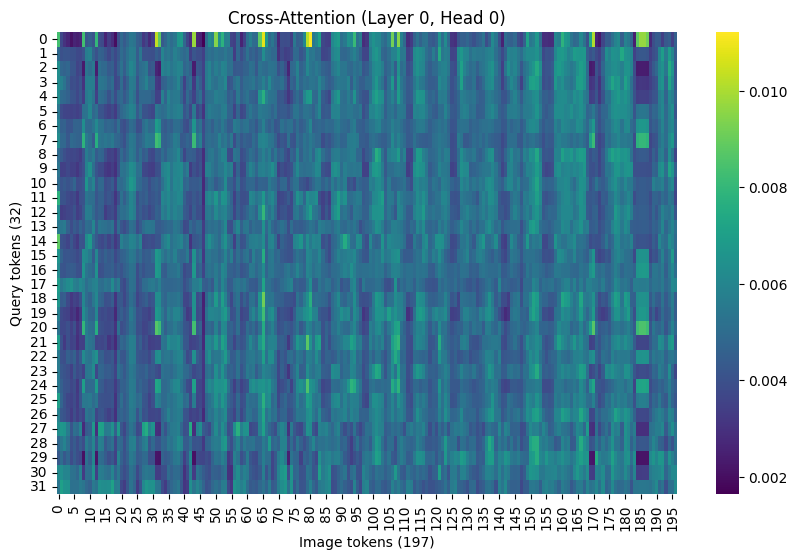

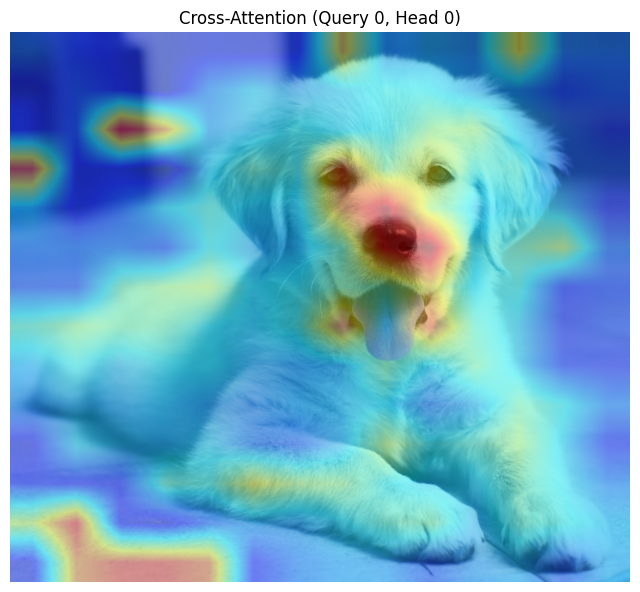

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, ViTModel
rank, num_tasks = 0, 1

# ============================================================
# 1. Encoders
# ============================================================
class TextEncoder(nn.Module):
    def __init__(self, model_name="bert-base-uncased"): #BertTokenizer [DEC] speciatl 토큰 추가
        super().__init__()
        self.model = BertModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask=None):
        out = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return out.last_hidden_state  # (B, L, D)


class ImageEncoder(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224", out_dim=768):
        super().__init__()
        self.model = ViTModel.from_pretrained(model_name)
        self.proj = nn.Linear(self.model.config.hidden_size, out_dim)

    def forward(self, x):
        out = self.model(pixel_values=x).last_hidden_state  # (B, N, D)
        return self.proj(out)


# ============================================================
# 2. Q-Former
# ============================================================
class QFormer(Blip2Base):
    def __init__(
        self, 
        vit_model="clip_B",
        img_size = 224,
        drop_path_rate=0,
        use_grad_checkpoint=False,
        vit_precision="fp16",
        freeze_vit = True,
        num_query_token=32,
        cross_attention_freq=2,
        embed_dim=256,
        max_txt_len=32,
    ):
        super().__init__()
        
        
        self.tokenizer= self.init_tokenizer()#BertTokenizer [DEC] speciatl 토큰 추가
        
        self.matching = False 
        self.caption = False 
        
        self.visual_encoder, self.ln_vision = self.init_vision_encoder(
            vit_model, img_size, drop_path_rate, use_grad_checkpoint,  vit_precision
        )
        
        
        if freeze_vit:
            for name, param in self.visual_encoder.named_parameters():
                param.requires_grad= False
                
            self.visual_encoder =self.visual_encoder.eval()
            self.visual_encoder.train = disabled_train 
            
            

        self.Qformer, self.query_tokens = self.init_Qformer(
            num_query_token, self.visual_encoder.config.hidden_size, cross_attention_freq
        ) #Qformer는 BertLMHeadModel, query token(1, 32, hidden_size)
        
        self.Qformer.resize_token_embeddings(len(self.tokenizer)) #bert tokenizer special token추가하고 임베딩 리사이즈
        
        state_dict = self.Qformer.state_dict()
        
        
        for name, param in self.Qformer.named_parameters():
            if "_query" in name:
                key_orig = name.replace("_query", "")
                param.data.copy_(state_dict(key_orig))
                

        if not self.caption:
            for name, param in self.Qformer.named_parameters():
                if 'cls.predictions' in name:
                    param.requires_grad =False 
                    
        
                    
        self.vision_proj = nn.Linear(self.Qformer.config.hidden_size, embed_dim)
        self.text_proj = nn.Linear(self.Qformer.config.hidden_size, embed_dim)
        
        if self.matching:
            self.itm_head = nn.Linear(self.Qformer.config.hidden_size, 2)
        
        self.temp = nn.Parameter(0.07 * torch.ones([]))
        self.max_txt_len = max_txt_len
        
        



    def forward(self, samples):
        
        image =samples["image"]
        text = samples["caption"]
            
        vit_out = self.visual_encoder(image)
        image_embeds = self.ln_vision(vit_out.last_hidden_state)  # ✅ 수정
        
        image_atts =  torch.ones(image_embeds.size()[:-1], dtype =torch.long).to(image.device)
        #모든 이미지 참조
        
        """ 1, n_Query, hidden인 것에 이미지 사이즈에 맞춰서 query 토큰 확장"""
        
        
        """1, n_Query, hidden인 것에 이미지 사이즈에 맞춰서 query 토큰 확장"""
        query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)
        
        
        query_output = self.Qformer.bert(
            inputs_embeds = query_tokens,
            encoder_hidden_states = image_embeds,#ViT feature참고
            encoder_attention_mask = image_atts, #모든 이미지 참조
            use_cache=True,
            return_dict =True,
            output_attentions=True,
            
        )
        # cross-attention 맵 확인
        cross_attns = getattr(query_output, "cross_attentions", None)

        if cross_attns is not None:
            print("Cross-attention layers:", len(cross_attns))
            # 예: 첫 번째 레이어, 첫 번째 배치, 첫 번째 헤드
            attn_map = cross_attns[0][0][0].detach().cpu()  
            print("Attention shape:", attn_map.shape)  
            # (query_len, image_seq_len)


        """query_output의 last hidden state를  
        vision_proj 통과시킨, embedding Normalize해서 image_feats 뽑음."""
        image_feats = F.normalize(
            self.vision_proj(query_output.last_hidden_state),dim=-1
        ) 
        
        """bert tokenizing 과정"""
        text_tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation= True,
            max_length=self.max_txt_len,
            return_tensors="pt",
        ).to(image.device)
        
        
        text_output= self.Qformer.bert(
            text_tokens.input_ids,
            attention_mask=text_tokens.attention_mask,
            return_dict=True,
        )
        
        text_feat = F.normalize(
            self.text_proj(text_output.last_hidden_state[:, 0, :]), dim=-1
        )
        
        
        
        ###============== Image-text Contrastive ===================###
        
        """여러 GPU에서 연산된, Feats, texts 합침."""
        image_feats_all = concat_all_gather(
            image_feats
        ) 
        text_feat_all = concat_all_gather(text_feat)
        
        
        
        """image 하나  & text all"""
        sim_q2t = torch.matmul(
            image_feats.unsqueeze(1), text_feat_all.unsqueeze(-1)
        ).squeeze() # (B 1 D) @ (N D 1) -> (B, N, 1)
        
        
        sim_i2t, _ = sim_q2t.max(-1) # (B, N)에서 N 가져옴. 텍스트 개수 전체 ? -> 각 이미지에 대해 가장 잘 맞는 텍스트와 유사도를 고름.
        
        sim_i2t = sim_i2t / self.temp
        
        
        
        # text-query similarity: [batch_size, batch_size*num_gpu, num_query_tokens]
        """text 하나  & image all"""
        sim_t2q = torch.matmul(
            text_feat.unsqueeze(1).unsqueeze(1), image_feats_all.permute(0, 2, 1)
        ).squeeze()
        
        sim_t2i, _ = sim_t2q.max(-1)
        #sim_t2i = sim_t2q.mean(-1)
        sim_t2i = sim_t2i/ self.temp # [batch_size, batch_size*num_gpu]

        
        rank = 0

        
        """DDP에서 각 GPU는 배치를 따로 가지기에 각 GPU가 가진 샘플의 GLOBAL 인덱스 시작 위치를 맞춤"""
        bs = image.size(0)
        
        targets = torch.linspace(rank * bs, rank * bs + bs - 1, bs, dtype=int).to(
            image.device
        )
        # image * text all + text * image all contrastive Loss Image Text Contrastive Loss
        loss_itc = (
            F.cross_entropy(sim_i2t, targets, label_smoothing=0.1)
            + F.cross_entropy(sim_t2i, targets, label_smoothing=0.1)
        ) / 2
        
        ###============== Image-text Matching ===================###
        
        loss_itm = 0.0
        
        if self.matching:
            text_input_ids_world = concat_all_gather(text_tokens.input_ids)
            text_attention_mask_world = concat_all_gather(text_tokens.attention_mask)
            image_embeds_world = all_gather_with_grad(image_embeds)
            
            with  torch.no_grad():
                weight_t2i = F.softmax(sim_t2i, dim=1) + 1e-4 # N,B 에서 확률 분포로 바꿈 텍스트 하나당 어떤 이미지가 그럴듯한지 Softmax
                weight_t2i[:, rank * bs : rank * bs + bs].fill_diagonal_(0)
                
                weights_i2t = F.softmax(simi2t, dim=1) + 1e-4 # 이미지가 어떤 텍스트가 맞을지 확률화
                weights_i2t[:, rank * bs : rank * bs + bs].fill_diagonal_(0)
                
            # 위의 weights는 샘플링 확률로 사용됨. 
            
            # 텍스트 기준 -> 가장 유사한 이미지 중에서 negative 샘플 뽑기 .
            # 이미지 기준 -> 가장 유사한 텍스트 중에서 negative 샘플 뽑기 .
            
            # 일부러 하드한 negative 쌍을 뽑는 과정 
            
            image_embeds_neg = []
            """b번째 text 모든 image 유사도 확률분포 : weights_t2i[b]"""
            
            for b in range(bs):
                neg_idx = torch.multinomial(weights_t2i[b], 1).item()
                image_embeds_neg.append(image_embeds_world[neg_idx])
                
            image_embeds_neg = torch.stack(image_embeds_neg, dim =0 )
            
            text_ids_neg = []
            text_atts_neg = []
            
            """b번째 image와 모든 text 유사도 확률분포 : weights_i2t[b]"""

            for b in range(bs):
                neg_idx = torch.multinomial(weights_i2[b], 1).item() 
                text_id_neg.append(text_input_ids_world[neg_idx])
                text_atts_neg.append(text_attention_mask_world[neg_idx])
                
            text_ids_neg = torch.staack(text_ids_neg, dim=0) 
            text_atts_neg = torch.stack(text_atts_neg, dim=0)
            
            text_ids_all = torch.cat(
                [text_tokens.input_ids, text_tokens.input_ids, text_ids_neg], dim =0
            )
            # Text 마스크
            text_atts_all = torch.cat(
                [text_tokens.attention_mask, text_tokens.attention_mask, text_atts_neg],
                dim=0,
            )
            ## 배치마다 query 복제
            query_tokens_itm = self.query_tokens.expand(text_ids_all.shape[0], -1, -1)
            
            query_atts_itm = torch.ones(query_tokens_itm.size()[:-1], dtype=torch.long).to(
            image.device
            )
            
            attention_mask_all = torch.cat([query_atts_itm, text_atts_all], dim =1)
            
            """image_embeds, image_embeds_neg, image_embeds cat"""
            image_embeds_all = torch.cat(
                [image_embeds, image_embeds_neg, image_embeds], dim=0
            )  # pos, neg, pos
            
            """image_embeds, image_embeds_neg, image_embeds cat"""
            image_atts_all = torch.ones(image_embeds_all.size()[:-1], dtype=torch.long).to(
                image.device
            )
            """output_itm bert"""
            output_itm = self.Qformer.bert(
                text_ids_all,
                inputs_embeds=query_tokens_itm,
                attention_mask=attention_mask_all,
                encoder_hidden_states=image_embeds_all,
                encoder_attention_mask=image_atts_all,
                return_dict=True,
            )
            
            # ITM 판단에 쓸 query 토큰 임베딩만 가져옴.
            vl_embeddings = output_itm.last_hidden_state[:, : query_tokens_itm.size(1), :]
            vl_output = self.itm_head(vl_embeddings)
            logits = vl_output.mean(dim=1)

            itm_labels = torch.cat(
                [torch.ones(bs, dtype=torch.long), torch.zeros(2 * bs, dtype=torch.long)],
                dim=0,
            ).to(image.device)
            
            """ logits 와 itm label cross entropy loss 구하기 """
            loss_itm = F.cross_entropy(logits, itm_labels)
            
            
            ##================= Image Captioning ========================##
            loss_lm = 0.0
            if self.caption:
                decoder_input_ids = text_tokens.input_ids.clone()
                decoder_input_ids[:, 0] = self.tokenizer.bos_token_id
                labels = decoder_input_ids.masked_fill(
                    decoder_input_ids == self.tokenizer.pad_token_id, -100
                )

                query_atts = torch.ones(query_tokens.size()[:-1], dtype=torch.long).to(
                    image.device
                )
                attention_mask = torch.cat([query_atts, text_tokens.attention_mask], dim=1)
                lm_output = self.Qformer(
                    decoder_input_ids,
                    attention_mask=attention_mask,
                    past_key_values=query_output.past_key_values,
                    return_dict=True,
                    labels=labels,
                )

                loss_lm = lm_output.loss

            return BlipOutput(
                loss=loss_itc + loss_itm + loss_lm,
                loss_itc=loss_itc,
                loss_itm=loss_itm,
                loss_lm=loss_lm,
            )

            
            
        loss_itm = 0.0
        if self.matching:
            text_input_ids_world = concat_all_gather(text_tokens.input_ids)
            text_attention_mask_world = concat_all_gather(text_tokens.attention_mask)
            image_embeds_world = all_gather_with_grad(image_embeds)
            with torch.no_grad():
                weights_t2i = F.softmax(sim_t2i, dim=1) + 1e-4
                weights_t2i[:, rank * bs : rank * bs + bs].fill_diagonal_(0)
                weights_i2t = F.softmax(sim_i2t, dim=1) + 1e-4
                weights_i2t[:, rank * bs : rank * bs + bs].fill_diagonal_(0)


            """Image Negative 쌍 선택"""
            # select a negative image for each text
            image_embeds_neg = []
            for b in range(bs):
                neg_idx = torch.multinomial(weights_t2i[b], 1).item()
                image_embeds_neg.append(image_embeds_world[neg_idx])
            image_embeds_neg = torch.stack(image_embeds_neg, dim=0)

            """Text Negative 쌍 선택"""
            # select a negative text for each image
            text_ids_neg = []
            text_atts_neg = []
            for b in range(bs):
                neg_idx = torch.multinomial(weights_i2t[b], 1).item()
                text_ids_neg.append(text_input_ids_world[neg_idx])
                text_atts_neg.append(text_attention_mask_world[neg_idx])

            text_ids_neg = torch.stack(text_ids_neg, dim=0)
            text_atts_neg = torch.stack(text_atts_neg, dim=0)

            text_ids_all = torch.cat(
                [text_tokens.input_ids, text_tokens.input_ids, text_ids_neg], dim=0
            )  # pos, pos, neg
            text_atts_all = torch.cat(
                [text_tokens.attention_mask, text_tokens.attention_mask, text_atts_neg],
                dim=0,
            )
            
            """Query 토큰에 Text_ids_all 담음 for ITM"""
            query_tokens_itm = self.query_tokens.expand(text_ids_all.shape[0], -1, -1)
            query_atts_itm = torch.ones(query_tokens_itm.size()[:-1], dtype=torch.long).to(
                image.device
            )
            
            """Attention? maks"""
            attention_mask_all = torch.cat([query_atts_itm, text_atts_all], dim=1)

            """image_embeds, image_embeds_neg, image_embeds cat"""
            image_embeds_all = torch.cat(
                [image_embeds, image_embeds_neg, image_embeds], dim=0
            )  # pos, neg, pos
            
            """image_embeds, image_embeds_neg, image_embeds cat"""
            image_atts_all = torch.ones(image_embeds_all.size()[:-1], dtype=torch.long).to(
                image.device
            )
            """output_itm bert"""
            output_itm = self.Qformer.bert(
                text_ids_all,
                inputs_embeds=query_tokens_itm,
                attention_mask=attention_mask_all,
                encoder_hidden_states=image_embeds_all,
                encoder_attention_mask=image_atts_all,
                return_dict=True,
            )

            vl_embeddings = output_itm.last_hidden_state[:, : query_tokens_itm.size(1), :]
            vl_output = self.itm_head(vl_embeddings) # (Qformer. hidden , 2) 0,1 차원
            logits = vl_output.mean(dim=1)

            itm_labels = torch.cat(
                [torch.ones(bs, dtype=torch.long), torch.zeros(2 * bs, dtype=torch.long)],
                dim=0,
            ).to(image.device)
            """ logits 와 itm label cross entropy loss 구하기 """
            loss_itm = F.cross_entropy(logits, itm_labels) # 분류 로스

        ##================= Image Captioning ========================##
        loss_lm = 0.0
        if self.caption:
            decoder_input_ids = text_tokens.input_ids.clone() #정답 토큰 ID
            decoder_input_ids[:, 0] = self.tokenizer.bos_token_id #decoder 시작을 BOS 토큰으로 교체
            labels = decoder_input_ids.masked_fill(
                decoder_input_ids == self.tokenizer.pad_token_id, -100
            ) #패드 토큰은 Loss에서 제외하여, 문장 길이 제각각이어도 학습하게끔.

            query_atts = torch.ones(query_tokens.size()[:-1], dtype=torch.long).to(
                image.device #query 토큰 전부 활성화 
            )
            attention_mask = torch.cat([query_atts, text_tokens.attention_mask], dim=1)
            lm_output = self.Qformer(
                decoder_input_ids,
                attention_mask=attention_mask,
                past_key_values=query_output.past_key_values,
                return_dict=True,
                labels=labels,
            )

            loss_lm = lm_output.loss

        return BlipOutput(
            loss=loss_itc + loss_itm + loss_lm,
            loss_itc=loss_itc,
            loss_itm=loss_itm,
            loss_lm=loss_lm,
            cross_attns=query_output.cross_attentions   # 👈 추가
        )



# ============================================================
# 3. Full Model (Encoders + QFormer)
# ============================================================
import torch
import torch.distributed as dist
from PIL import Image
from torchvision import transforms
import cv2
import numpy as np
import seaborn as sns

if dist.is_available() and dist.is_initialized():
    rank = 0
else:
    rank = 0   # 단일 GPU에서는 그냥 0으로 고정

# 모델 초기화
model = QFormer().cuda()
model.eval()

image_path = r"D:\Qformer_tutorial\dog3.jpg"

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),           
    transforms.Normalize(            
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
img = Image.open(image_path).convert("RGB")
img_tensor = preprocess(img).unsqueeze(0).cuda()  # (1, 3, 224, 224)
img_np = np.array(img)  # (H, W, C)
imgs = torch.cat([img_tensor, img_tensor], dim=0)  # (2, 3, 224, 224)

captions = ["a cat on the mat","a dog in the park"]  
samples = {"image": imgs, "caption": captions}

with torch.no_grad():
    output = model(samples)

print("ITC loss:", output.loss_itc.item())
print("ITM loss:", output.loss_itm)
print("LM loss:", output.loss_lm)
print("Total loss:", output.loss)


cross_attns = output.cross_attns
if cross_attns is not None:
    print("Cross-attention layers:", len(cross_attns))
    attn_map = cross_attns[0][0][0].detach().cpu().numpy()
    print("attn_map shape:", attn_map.shape)
else:
    print(" cross_attns가 여전히 None입니다.")


plt.figure(figsize=(10, 6))
sns.heatmap(attn_map, cmap="viridis")
plt.title("Cross-Attention (Layer 0, Head 0)")
plt.xlabel("Image tokens (197)")
plt.ylabel("Query tokens (32)")
plt.show()


attn_map = cross_attns[0][0][0].detach().cpu().numpy()  
attn_for_vis = attn_map[0]
attn_patches = attn_for_vis[1:].reshape(14, 14)
attn_resized = cv2.resize(attn_patches, (img_np.shape[1], img_np.shape[0]))
attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min())
heatmap = cv2.applyColorMap(np.uint8(255 * attn_resized), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(8, 8))
plt.imshow(overlay[..., ::-1]) 
plt.axis("off")
plt.title("Cross-Attention (Query 0, Head 0)")
plt.show()




토큰: ['[CLS]', 'a', 'dog', 'in', 'the', 'park', '[SEP]']


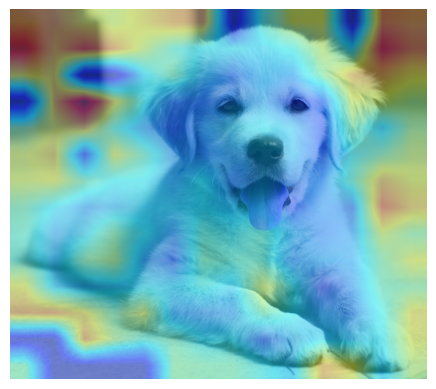

In [63]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

# 1. 토크나이저 준비
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 2. 문장 토큰화
text = "a dog in the park"
inputs = tokenizer(text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print("토큰:", tokens)

# 3. 'dog' 토큰 인덱스 찾기
word = "dog"
query_idx = tokens.index(word)  # "dog" 위치

# 4. cross-attention 가져오기
attn_layer0 = cross_attns[1][1]   # 첫 레이어, 배치 0
attn_word = attn_layer0.mean(0)[query_idx]  # head 평균 후 "dog" query만 선택
attn_word = attn_word[1:].reshape(14, 14)

# 5. numpy 변환 + 정규화
attn_map = attn_word.detach().cpu().numpy()   # <-- numpy 변환 추가
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

# 6. 원본 이미지 크기 확인# 6. 원본 이미지 크기 확인
img_np = np.array(img)  # PIL -> numpy (H, W, C)
h, w, _ = img_np.shape

# 7. attention 맵을 이미지 크기에 맞게 리사이즈
attn_map = cv2.resize(attn_map, (w, h))

# 8. heatmap 생성
heatmap = cv2.applyColorMap(np.uint8(255 * attn_map), cv2.COLORMAP_JET)

# 9. 원본 이미지와 합성 (0.6 비율)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# 10. 출력
plt.imshow(overlay[..., ::-1])  # OpenCV BGR → Matplotlib RGB
plt.axis("off")
plt.show()


In [65]:
print("Cross-attention layers:", len(cross_attns))
for i, attn in enumerate(cross_attns):
    print(f"Layer {i} shape:", attn.shape)


Cross-attention layers: 12
Layer 0 shape: torch.Size([2, 12, 32, 197])
Layer 1 shape: torch.Size([2, 12, 32, 197])
Layer 2 shape: torch.Size([2, 12, 32, 197])
Layer 3 shape: torch.Size([2, 12, 32, 197])
Layer 4 shape: torch.Size([2, 12, 32, 197])
Layer 5 shape: torch.Size([2, 12, 32, 197])
Layer 6 shape: torch.Size([2, 12, 32, 197])
Layer 7 shape: torch.Size([2, 12, 32, 197])
Layer 8 shape: torch.Size([2, 12, 32, 197])
Layer 9 shape: torch.Size([2, 12, 32, 197])
Layer 10 shape: torch.Size([2, 12, 32, 197])
Layer 11 shape: torch.Size([2, 12, 32, 197])


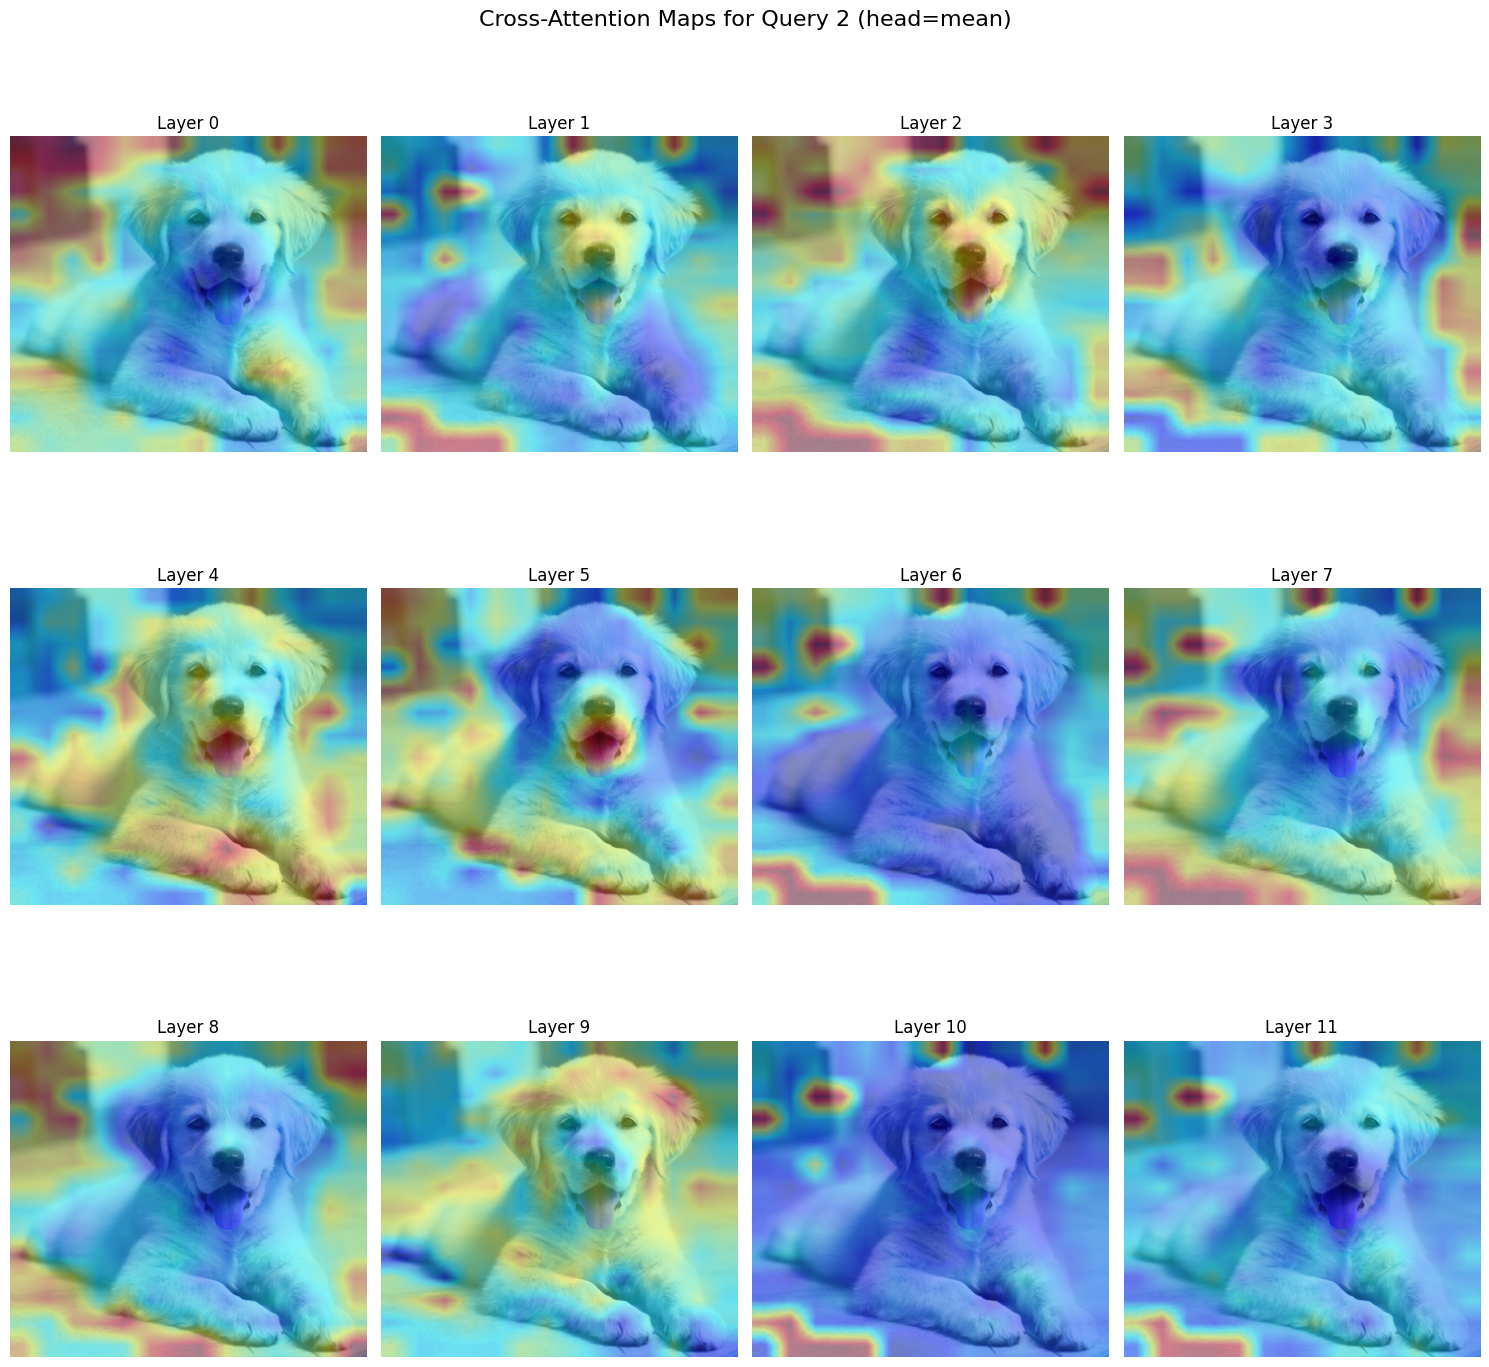

In [84]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_all_layers(cross_attns, img_np, query_idx, head_agg="mean"):
    """
    cross_attns: 모델 output.cross_attns
    img_np: 원본 이미지 (H, W, 3)
    query_idx: 보고 싶은 query 토큰 인덱스 (예: "dog" 위치)
    head_agg: 'mean' 또는 특정 head 번호(int)
    """
    num_layers = len(cross_attns)
    h, w, _ = img_np.shape

    plt.figure(figsize=(15, 15))

    for layer_idx in range(num_layers):
        attn_layer = cross_attns[layer_idx][0]  # batch=0
        if head_agg == "mean":
            attn_word = attn_layer.mean(0)[query_idx]
        else:
            attn_word = attn_layer[head_agg][query_idx]

        # CLS 제외 → 14x14
        attn_word = attn_word[1:].reshape(14, 14)
        attn_map = attn_word.detach().cpu().numpy()
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

        # 원본 크기로 리사이즈
        attn_resized = cv2.resize(attn_map, (w, h))
        heatmap = cv2.applyColorMap(np.uint8(255 * attn_resized), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

        # subplot에 배치
        plt.subplot(3, 4, layer_idx+1)
        plt.imshow(overlay[..., ::-1])  # BGR→RGB
        plt.title(f"Layer {layer_idx}")
        plt.axis("off")

    plt.suptitle(f"Cross-Attention Maps for Query {query_idx} (head={head_agg})", fontsize=16)
    plt.tight_layout()
    plt.show()

# 예시 실행
query_idx = tokens.index("dog")  # "dog" 위치
# query_idx =28
visualize_all_layers(cross_attns, img_np, query_idx, head_agg="mean")
